In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PyCORe_main_cp as pcm
from scipy.constants import hbar
import ipywidgets
import matplotlib
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import complex_ode, solve_ivp
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from scipy.constants import pi, c, hbar
from matplotlib.widgets import Slider, Button, TextBox
from matplotlib.animation import FuncAnimation
import matplotlib.image as mpimg
from scipy.optimize import curve_fit, root
import time
from scipy.sparse import block_diag, identity, diags
import scipy.integrate as integrate
from tqdm import tqdm

# In[18]:


class Resonator:
    def __init__(self, resonator_parameters):
        #Initialization of physical parameters
        self.n0=resonator_parameters['n0']
        self.n2=resonator_parameters['n2']
        self.FSR=resonator_parameters['FSR']
        self.w0=resonator_parameters['w0']
        self.width=resonator_parameters['width']
        self.height=resonator_parameters['height']
        self.kappa_0=resonator_parameters['kappa_0']
        self.kappa_ex=resonator_parameters['kappa_ex']
        self.beta=resonator_parameters['beta']
        self.alpha=resonator_parameters['alpha']
        self.Dint=np.fft.ifftshift(resonator_parameters['Dint'])
       
        #Auxiliary physical parameters
        self.Tr=1/self.FSR
        self.Aeff=self.width*self.height
        self.Leff=c/self.n0*self.Tr
        self.Veff=self.Aeff*self.Leff
        self.g0=hbar*self.w0**2*c*self.n2/self.n0**2/self.Veff
        self.gamma=self.n2*self.w0/c/self.Aeff
        self.kappa=self.kappa_0+self.kappa_ex
        self.N_points=len(self.Dint)
        self.k_theta=resonator_parameters['thermal_time']*self.kappa
        self.r_theta=resonator_parameters['thermal_Kerr']
        mu=np.fft.fftshift(np.arange(-self.N_points/2, self.N_points/2))
        def func(x, a, b, c, d):
            return a+x*b+c*x**2/2+d*x**3/6
        popt, pcov=curve_fit(func, mu, self.Dint)
        self.D2=popt[2]
        self.D3=popt[3]
        
    def noise(self, a):
        return a*(np.random.uniform(-1,1, self.N_points)+1j*np.random.uniform(-1,1,self.N_points))
    
    
    def Propagate_SAM(self, simulation_parameters, Pump, Seed=[0]):
        start_time=time.time()
        
        T=simulation_parameters['slow_time']
        abtol=simulation_parameters['absolute_tolerance']
        reltol=simulation_parameters['relative_tolerance']
        out_param=simulation_parameters['output']
        nmax=simulation_parameters['max_internal_steps']
        detuning=simulation_parameters['detuning_array']
        eps=simulation_parameters['noise_level']
        
        pump=Pump*np.sqrt(1./(hbar*self.w0))
        if Seed[0] == 0:
            seed=self.seed_level(Pump, detuning[0])*np.sqrt(2*self.g0/self.kappa)
        else:
            seed=Seed*np.sqrt(2*self.g0/self.kappa)
        ### Renormalization
        T_rn=(self.kappa/2)*T
        f0=pump*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        print('f0^2='+str(np.round(max(abs(f0)**2), 2)))
        print('xi ['+str(detuning[0]*2/self.kappa)+','+str(detuning[-1]*2/self.kappa)+']')
        noise_const=self.noise(eps)
        nn=len(detuning)
        
        ###detuning the rhs functions 
        def LLE_1d(Time, A):
            A=A-noise_const
            A_dir=np.fft.fft(A)
            dAdT = -1 * (1 + 1j*(self.Dint + dOm_curr)*2/self.kappa)*A+1j*np.fft.ifft(A_dir*np.abs(A_dir)**2) + f0
            return dAdT 
        t_st=float(T_rn)/len(detuning)
        r=complex_ode(LLE_1d).set_integrator('dopri5', atol=abtol, rtol=reltol, nsteps=nmax) #set the solver
        r.set_initial_value(seed, 0) #seed the cavity
        sol=np.ndarray(shape=(len(detuning), self.N_points), dtype='complex')
        sol[0,:]=seed
        for it in tqdm(range(1, len(detuning))):
            #self.printProgressBar(it+1, nn, prefix='Progress:', suffix='Complete', time='elapsed time='+'{:04.1f}'.format(time.time()))
            dOm_curr=detuning[it]
            sol[it]=r.integrate(r.t+t_st)
            
        if out_param=='map':
            return sol#/len(sol[0])
        elif out_param=='fin_res':
            return sol[-1,:]#/len(sol[0])
        else:
            print('wrong parameter')
            
    def Propagate_SplitStep(self, simulation_parameters, Pump, Seed=[0], dt=1e-3):
        start_time=time.time()
        T=simulation_parameters['slow_time']
        out_param=simulation_parameters['output']
        detuning=simulation_parameters['detuning_array']
        eps=simulation_parameters['noise_level']
        
        pump=Pump*np.sqrt(1./(hbar*self.w0))
        if Seed[0] == 0:
            seed = self.seed_level(Pump, detuning[0]) * np.sqrt(2*self.g0 /self.kappa)
        else:
            seed = Seed * np.sqrt(2*self.g0 / self.kappa)
            
        ### Renormalization
        T_rn=(self.kappa/2)*T
        f0=pump*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        print('f0^2='+str(np.round(max(abs(f0)**2), 2)))
        print('xi ['+str(detuning[0]*2/self.kappa)+','+str(detuning[-1]*2/self.kappa)+']')
        noise_const=self.noise(eps)
        nn=len(detuning)
        
        t_st=float(T_rn)/len(detuning)
        
        
        sol=np.ndarray(shape=(len(detuning), self.N_points), dtype='complex128') #define an array to store the data
        sol[0,:]=(seed)
        print(f0)
        print(sol[0,0])
        buf=sol[0]
        F = f0*len(buf)
        dOm_full =  - (1 + 1j * (self.Dint.reshape(1, -1) + detuning.reshape(-1,1)) * 2 / self.kappa)
        exp_Om_full = np.exp( dt * dOm_full)
        
        coeff_1 = F * (exp_Om_full - 1) / dOm_full
        #self.printProgressBar(0, nn, prefix='Progress:', suffix='Complete', length=50)
        for it in tqdm(range(1, len(detuning))):
            #self.printProgressBar(it+1, nn, prefix='Progress:', suffix='Complete,', time='elapsed time='+'{:04.1f}'.format(time.time()))
            dOm_curr=detuning[it] #detuning value
            t=0
            buf=sol[it-1]
            
            buf-=noise_const
            while t<t_st:
                buf_dir=np.fft.ifft(buf)
#                 f=np.fft.ifft(f0)*len(buf)
                #First step
                buf_dir=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir)**2))*buf_dir)
               
#                 buf=F * (np.exp( - dt * (1 + 1j * (self.Dint + dOm_curr) * 2 / self.kappa)) - 1)/dOm_full[it]\
#                 + np.exp( - dt * (1 + 1j * (self.Dint + dOm_curr) * 2 / self.kappa)) * buf_dir
                buf = coeff_1[it] + exp_Om_full[it] * buf_dir
                t+=dt
            sol[it]=buf
            
        if out_param=='map':
            return sol/len(buf)
        elif out_param=='fin_res':
            return sol[-1,:]/len(buf)
        else: 
            print('wrong parameter')
            
   

    def Propagate_SplitStep_back(self, simulation_parameters, Pump, Seed=[0], dt=1e-3):
        start_time=time.time()
        T=simulation_parameters['slow_time']
        out_param=simulation_parameters['output']
        detuning=simulation_parameters['detuning_array']
        eps=simulation_parameters['noise_level']
        
        pump=Pump*np.sqrt(1./(hbar*self.w0))
        if Seed[0] == 0:
            seed, seed_back = self.seed_level_back(Pump, detuning[0])
        else:
            seed = Seed
            seed_back=Seed
        ### Renormalization
        T_rn=(self.kappa/2)*T
        f0=pump*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        print('f0^2='+str(np.round(max(abs(f0)**2), 2)))
        print('xi ['+str(detuning[0]*2/self.kappa)+','+str(detuning[-1]*2/self.kappa)+']')
        noise_const=self.noise(eps)
        nn=len(detuning)
        
        t_st=float(T_rn)/len(detuning)
        
        
        sol=np.ndarray(shape=(len(detuning), self.N_points), dtype='complex') #define an array to store the data
        sol_back=np.ndarray(shape=(len(detuning), self.N_points), dtype='complex') #define an array to store the data
        sol[0,:]=(seed)
        sol_back[0,:]=(seed_back)
        print(f0)
        length=len(sol[0,:]) ### Number of considered modes in our model        
        K_for=-(1+1j*(self.Dint.reshape(1,-1)+detuning.reshape(-1,1))*2/self.kappa)
        K_back=-(1+1j*(self.Dint.reshape(1,-1)+detuning.reshape(-1,1))*2/self.kappa)
        #dOm_curr_exp=np.exp(-dt*(1+1j*dOm_curr*2/self.kappa)) #The coefficient in the second solver step
        pumping=f0*length
        backscattering_coeff=1j*self.beta
        forw_back_coup=2j*self.alpha
        ### Transform pumps into the time-domain (multiplication by length (N) is necessary to compensate the coefficient from FFT  in first step of solver)

        print(sol[0,0])
        print(sol_back[0,0])
        for it in tqdm(range(1, len(detuning))):

            t=0
            buf=sol[it-1]
            buf_back=sol_back[it-1]
            buf-=noise_const
            buf_back-=noise_const
            while t<t_st:
                buf_dir=np.fft.ifft(buf)
                buf_dir_back=np.fft.ifft(buf_back)
                buf_1=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir)**2))*buf_dir)
                buf_back_1=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir_back)**2))*buf_dir_back)
                #print(f)
                #First step
                #Second step
                K_forward=forw_back_coup*np.sum(np.abs(buf_back/length)**2)+K_for[it]
                K_backward=forw_back_coup*np.sum(np.abs(buf/length)**2)+K_back[it]
                
                exp_forward=np.exp(dt*K_forward)
                exp_backward=np.exp(dt*K_backward)
                buf=(pumping+backscattering_coeff*buf_back)*(exp_forward-1)/K_forward+exp_forward*buf_1
                buf_back=(backscattering_coeff*buf)*(exp_backward-1)/K_backward+exp_backward*buf_back_1
                
                t+=dt
            sol[it]=buf
            sol_back[it]=buf_back
        if out_param=='map':
            return sol/length, sol_back/length
        elif out_param=='fin_res':
            return sol[-1,:]
        else: 
            print('wrong parameter')
        
        
    def Propagate_SplitStep_back_thermal(self, simulation_parameters, Pump, Seed=[0], dt=1e-3):
        start_time=time.time()
        T=simulation_parameters['slow_time']
        out_param=simulation_parameters['output']
        detuning=simulation_parameters['detuning_array']
        eps=simulation_parameters['noise_level']
        pump=Pump*np.sqrt(1./(hbar*self.w0))
        if Seed[0] == 0:
            seed, seed_back, seed_theta = self.seed_level_back_thermal(Pump, detuning[0])
        else:
            seed = Seed
            seed_back=Seed
            seed_theta=Seed
        ### Renormalization
        T_rn=(self.kappa/2)*T
        f0=pump*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        print('f0^2='+str(np.round(max(abs(f0)**2), 2)))
        print('xi ['+str(detuning[0]*2/self.kappa)+','+str(detuning[-1]*2/self.kappa)+']')
        noise_const=self.noise(eps)
        nn=len(detuning)
        
        t_st=float(T_rn)/len(detuning)
        
        
        sol=np.ndarray(shape=(len(detuning), self.N_points), dtype='complex') #define an array to store the data
        sol_back=np.ndarray(shape=(len(detuning), self.N_points), dtype='complex') #define an array to store the data
        sol_theta=np.ndarray(shape=len(detuning), dtype='double')
        sol[0,:]=(seed)
        sol_back[0,:]=(seed_back)
        sol_theta[0]=(np.real(seed_theta))
        print(f0)
        length=len(sol[0,:]) ### Number of considered modes in our model        
        K_for=-(1+1j*(self.Dint.reshape(1,-1)+detuning.reshape(-1,1))*2/self.kappa)
        K_back=-(1+1j*(self.Dint.reshape(1,-1)+detuning.reshape(-1,1))*2/self.kappa)
        K_theta=-self.k_theta/self.kappa
        #dOm_curr_exp=np.exp(-dt*(1+1j*dOm_curr*2/self.kappa)) #The coefficient in the second solver step
        pumping=f0*length
        backscattering_coeff=1j*self.beta
        forw_back_coup=2j*self.alpha
        ### Transform pumps into the time-domain (multiplication by length (N) is necessary to compensate the coefficient from FFT  in first step of solver)

        print(sol[0,0])
        print(sol_back[0,0])
        print(sol_theta[0])
        for it in tqdm(range(1, len(detuning))):

            t=0
            buf=sol[it-1]
            buf_back=sol_back[it-1]
            theta=sol_theta[it-1]
            buf-=noise_const
            buf_back-=noise_const
            while t<t_st:
                
                buf_dir=np.fft.ifft(buf)
                buf_dir_back=np.fft.ifft(buf_back)
                buf_1=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir)**2))*buf_dir)
                buf_back_1=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir_back)**2))*buf_dir_back)
                #print(f)
                #First step
                #Second step
                K_forward=forw_back_coup*np.sum(np.abs(buf_back/length)**2)+K_for[it]+1j*theta
                K_backward=forw_back_coup*np.sum(np.abs(buf/length)**2)+K_back[it]+1j*theta
                A_theta=(-K_theta)*self.r_theta*(np.sum(np.abs(buf/length)**2+np.abs(buf_back/length)**2))
                exp_theta=np.exp(dt*K_theta)
                
                theta=A_theta*(exp_theta-1)/K_theta+exp_theta*theta
#                 theta+=A_theta*dt+K_theta*theta*dt
               
                exp_forward=np.exp(dt*K_forward)
                exp_backward=np.exp(dt*K_backward)
                buf=(pumping+backscattering_coeff*buf_back)*(exp_forward-1)/K_forward+exp_forward*buf_1
                buf_back=(backscattering_coeff*buf)*(exp_backward-1)/K_backward+exp_backward*buf_back_1
                
                t+=dt
            sol[it]=buf
            sol_back[it]=buf_back
            sol_theta[it]=theta
        if out_param=='map':
            return sol/length, sol_back/length, sol_theta
        elif out_param=='fin_res':
            return sol[-1,:]
        else: 
            print('wrong parameter')        


    def seed_level(self, pump, detuning):
        f_norm=pump*np.sqrt(1./(hbar*self.w0))*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        detuning_norm=detuning*2/self.kappa
        stat_roots=np.roots([1,-2*detuning_norm, (detuning_norm**2+1), -abs(f_norm[0])**2])
        ind_roots=[np.imag(ii)==0 for ii in stat_roots]
        res_seed=np.zeros_like(f_norm)
        res_seed[0]=abs(stat_roots[ind_roots])**.5/np.sqrt(2*self.g0/self.kappa)
        return res_seed
    
    def seed_level_back(self,pump, detuning):
        f_norm=pump*np.sqrt(1./(hbar*self.w0))*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        detuning_norm=2/self.kappa*(-detuning)
        def func(x):
            return [-x[0] - 1.j*detuning_norm*x[0] + 1.j*(np.abs(x[0])**2+2*self.alpha*(np.abs(x[1])**2))*x[0]+f_norm[0]+1.j*self.beta*x[1],
                    -x[1] - 1.j*detuning_norm*x[1] + 1.j*(np.abs(x[1])**2+2*self.alpha*(np.abs(x[0])**2))*x[1]+1.j*self.beta*x[0]]


        roots = root(func, [1. + 1.j, 1. + 1.j], method='broyden1').x
        res_seed=np.zeros_like(f_norm, dtype='complex')
        res_seed_back=np.zeros_like(f_norm, dtype='complex')

        res_seed[0]=roots[0]
        res_seed_back[0]=roots[1]
        return res_seed, res_seed_back
                             
    def seed_level_back_thermal(self,pump, detuning):
        f_norm=pump*np.sqrt(1./(hbar*self.w0))*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        detuning_norm=2/self.kappa*(-detuning)
        def func(x):
            return [-x[0] - 1.j*detuning_norm*x[0]+1.j*x[2]*x[0] + 1.j*(np.abs(x[0])**2+2*self.alpha*(np.abs(x[1])**2))*x[0]+f_norm[0]+1.j*self.beta*x[1],
                    -x[1] - 1.j*detuning_norm*x[1]+1.j*x[2]*x[1] + 1.j*(np.abs(x[1])**2+2*self.alpha*(np.abs(x[0])**2))*x[1]+1.j*self.beta*x[0],
                   self.k_theta/self.kappa*(self.r_theta*(np.abs(x[0])**2+np.abs(x[1])**2)-x[2])]


        roots = root(func, [1. + 1.j, 1. + 1.j, 1.], method='broyden1').x
        res_seed=np.zeros_like(f_norm, dtype='complex')
        res_seed_back=np.zeros_like(f_norm, dtype='complex')
        #res_seed_back_thermal=np.zeros_like(f_norm, dtype='double')
        res_seed[0]=roots[0]
        res_seed_back[0]=roots[1]
        res_seed_back_thermal=roots[2]
        return res_seed, res_seed_back, res_seed_back_thermal
 

In [ ]:
"""class Resonator:
    def __init__(self, resonator_parameters):
        #Initialization of physical parameters
        self.n0=resonator_parameters['n0']
        self.n2=resonator_parameters['n2']
        self.FSR=resonator_parameters['FSR']
        self.w0=resonator_parameters['w0']
        self.width=resonator_parameters['width']
        self.height=resonator_parameters['height']
        self.kappa_0=resonator_parameters['kappa_0']
        self.kappa_ex=resonator_parameters['kappa_ex']
        self.Dint=np.fft.ifftshift(resonator_parameters['Dint'])
        self.n=resonator_parameters['n_pump']
        #Auxiliary physical parameters
        self.Tr=1/self.FSR
        self.Aeff=self.width*self.height
        self.Leff=c/self.n0*self.Tr
        self.Veff=self.Aeff*self.Leff
        self.g0=hbar*self.w0**2*c*self.n2/self.n0**2/self.Veff
        self.gamma=self.n2*self.w0/c/self.Aeff
        self.kappa=self.kappa_0+self.kappa_ex
        self.r_theta=resonator_parameters['thermal_Kerr']
        self.k_theta=resonator_parameters['thermal_time']*self.kappa
        self.N_points=len(self.Dint)
        mu=np.fft.fftshift(np.arange(-self.N_points/2, self.N_points/2))
        self.mu=np.fft.fftshift(np.arange(-self.N_points/2, self.N_points/2))
        def func(x, a, b, c, d):
            return a+x*b+c*x**2/2+d*x**3/6
        popt, pcov=curve_fit(func, mu, self.Dint)
        self.D2=popt[2]
        self.D3=popt[3]
        self.N_micro=resonator_parameters['N_micro']
        self.attempt_num=resonator_parameters['attempt_num']
        self.dzeta=resonator_parameters['dzeta']*2/self.kappa
        self.seed_coup=np.zeros((self.attempt_num, self.N_micro, np.shape(mu)[0]), dtype=np.complex128)
        self.seed_theta=np.zeros((self.attempt_num, self.N_micro), dtype=np.double)
        self.pump_coup=np.zeros_like(self.seed_coup, dtype=np.complex128)
        
        self.seed_coup_single=np.zeros((np.shape(mu)[0]), dtype=np.complex128)
        self.pump_coup_single=np.zeros_like(self.seed_coup_single, dtype=np.complex128)
        self.alpha=resonator_parameters['alpha']
        self.beta=resonator_parameters['beta']
        self.beta_star=np.conjugate(self.beta)
    ### Noise initialisation
    def noise(self, a):
        return a*(2*np.random.rand(self.attempt_num, self.N_micro, self.N_points)-1+1j*(2*np.random.rand(self.attempt_num, self.N_micro, self.N_points)-1))
    
    
    
    def Propagate_SplitStep_dual(self, simulation_parameters, Pump,   Seed=[0], dt=1e-3):
        ### Initialisation parameters for solver
        start_time=time.time()
        T=simulation_parameters['slow_time']
        out_param=simulation_parameters['output']
        detuning1=simulation_parameters['detuning_array1']
        detuning2=simulation_parameters['detuning_array2']
        eps=simulation_parameters['noise_level']

        pump_c=self.pump_coup
        seed_c=self.seed_coup
        seed_c_back=self.seed_coup.copy()
        pump_c[:,:]=Pump*np.sqrt(1./(hbar*self.w0))

        if Seed == [0]:
            seed_c[:,:] = self.seed_level_two_pumps(Pump, detuning1[0], detuning2[0])
            #seed_c[:,:],  seed_c_back[:,:] = self.seed_level_two_pumps_back(Pump, detuning1[0], detuning2[0])
        else:
            seed_c[:,:] = Seed
            #seed_c_back[:,:] = Seed
        ### Renormalization
        T_rn=(self.kappa/2)*T
        f0=pump_c*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        noise_const=self.noise(eps)
        nn=len(detuning1)
        random_attempt=np.random.randint(self.attempt_num)
        t_st=float(T_rn)/len(detuning1)


        sol=np.ndarray(shape=(self.attempt_num, self.N_micro,  self.N_points), dtype='complex128') #define an array to store the data
        sol_eval=np.ndarray(shape=(len(detuning1), self.N_micro,  self.N_points), dtype='complex128') #define an array to store the data
        #sol_back=np.ndarray(shape=(self.attempt_num, self.N_micro,  self.N_points), dtype='complex128')
        #sol_back_eval=np.ndarray(shape=(len(detuning1), self.N_micro,  self.N_points), dtype='complex128')
        sol[:,:,:]=(seed_c)
        #sol_back[:,:,:]=(seed_c_back)

        #print(sol[0,0,:])
        #print(sol_back[0,0,:])
        

        
        ##Calculate effective detuning (zeta in our texts)
        num_det=np.arange(len(detuning1))
        dOm_curr=-(detuning1[num_det]+detuning2[num_det]).reshape(-1,1)/2-(detuning1[num_det]-detuning2[num_det]).reshape(-1,1)/2/self.n*self.mu+self.Dint #detuning value
        
        ### Initial values of amplitudes
        buf=sol.copy()
        #buf_back=sol_back.copy()
        sol_eval[0]=sol[random_attempt]
        #sol_back_eval[0]=sol_back[random_attempt]
        length=len(buf[0,0,:]) ### Number of considered modes in our model        
        K_for=-(1 + 1j * dOm_curr * 2/self.kappa)
        #K_back=-(1+1j*dOm_curr*2/self.kappa)
        #dOm_curr_exp=np.exp(-dt*(1+1j*dOm_curr*2/self.kappa)) #The coefficient in the second solver step
        pumping=f0*length
        #backscattering_coeff=1j*self.beta
        #forw_back_coup=2j*self.alpha
        ### Transform pumps into the time-domain (multiplication by length (N) is necessary to compensate the coefficient from FFT  in first step of solver)
        f=np.fft.ifft(f0,axis=2)*length 
        
        #Start to solve
        for it in tqdm(range(1, len(detuning1))):
            t=0
            buf=sol-noise_const
            #if it==1:
                #continue
            #buf_back=sol_back-noise_const
            #else:
            #    buf_back=sol_back-noise_const
            exp_forward=np.exp(dt * K_for[it])
            
            total_pumping = pumping * (exp_forward - 1) / K_for[it]
#             buf=(pumping+backscattering_coeff*buf_dir_back)*(exp_forward-1)/K_forward + exp_forward*buf_dir

            while t<t_st:
                # First step
                ### Transform amplitudes into the direct-space
                buf_dir=np.fft.ifft(buf, axis=2)
                #buf_dir_back=np.fft.ifft(buf_back, axis=2)

                # Calculation of the first step of solver and transformation back into the frequency-space
                ### IMPORTANT Due to Numpy FFT and IFFT formulation the final value will be multiplied by the coefficient "length" which is the number of modes N in our model.
                # The final solution is Num_of_modes*a. Don't forget divide into the number of modes after solving.
               
                buf_dir=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir)**2))*buf_dir, axis=2)
                #buf_dir_back=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir_back)**2))*buf_dir_back, axis=2)
                
                # Second step
                ### Calculate the second step of split-step method
                #K_backward=forw_back_coup*np.sum(np.abs(buf_dir/length)**2, axis=2)+K_back[it]
                #exp_backward=np.exp(dt*K_backward)
                buf = total_pumping + exp_forward * buf_dir
                #buf_back=(backscattering_coeff*buf_dir)*(exp_backward-1)/K_backward+exp_backward*buf_dir_back                                             
                                                       
                                                     
                t+=dt
                
            sol=buf.copy() ### Current step of all attempts
            sol_eval[it]=sol[random_attempt] ### Time-evolution of one attempt
            #sol_back=buf_back.copy()
            #sol_back_eval[it]=sol_back[random_attempt]
        ### Final solutions
        ### Here we don't forget to divide the solution by the number of modes  (length)!!!
        if out_param=='map':
            return sol/length, sol_eval/length,  detuning1, detuning2 
        elif out_param=='fin_res':
            return sol[-1,:]/length
        else: 
            print('wrong parameter')
            
    def Propagate_SplitStep_dual_single_ring(self, simulation_parameters, Pump,   Seed=[0], dt=1e-3):
        ### Initialisation parameters for solver
        start_time=time.time()
        T=simulation_parameters['slow_time']
        out_param=simulation_parameters['output']
        detuning1=simulation_parameters['detuning_array1']
        detuning2=simulation_parameters['detuning_array2']
        eps = simulation_parameters['noise_level']

        pump_c = self.pump_coup_single
        seed_c = self.seed_coup_single
        pump_c= Pump * np.sqrt(1. / (hbar * self.w0))

        if Seed == [0]:
            seed_c = self.seed_level_two_pumps(Pump, detuning1[0], detuning2[0])
        else:
            seed_c = Seed
            #seed_c_back[:,:] = Seed
        ### Renormalization
        T_rn=(self.kappa/2)*T
        f0=pump_c*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        noise_const=self.noise(eps)
        nn=len(detuning1)
        random_attempt=np.random.randint(self.attempt_num)
        t_st=float(T_rn)/len(detuning1)


        sol = np.ndarray(shape = (self.N_points), dtype='complex128') #define an array to store the 
        sol_eval = np.ndarray(shape = (len(detuning1), self.N_points), dtype='complex128') #define an array to store 
        sol[:] = (seed_c)

        
        ##Calculate effective detuning (zeta in our texts)
        num_det = np.arange(len(detuning1))
        dOm_curr = - (detuning1[num_det] + detuning2[num_det]).reshape(-1,1) / 2 - (detuning1[num_det] - detuning2[num_det]).reshape(-1,1) / 2 / self.n * self.mu + self.Dint #detuning value
        
        ### Initial values of amplitudes
        buf = sol.copy()
        #buf_back=sol_back.copy()
        #sol_eval[0]=sol[random_attempt]
        #sol_back_eval[0]=sol_back[random_attempt]
        length = len(buf) ### Number of considered modes in our model        
        K_for = - (1 + 1j * dOm_curr * 2 / self.kappa)
        #K_back=-(1+1j*dOm_curr*2/self.kappa)
        #dOm_curr_exp=np.exp(-dt*(1+1j*dOm_curr*2/self.kappa)) #The coefficient in the second solver step
        pumping = f0 * length
        #backscattering_coeff=1j*self.beta
        #forw_back_coup=2j*self.alpha
        ### Transform pumps into the time-domain (multiplication by length (N) is necessary to compensate the coefficient from FFT  in first step of solver)
        f = np.fft.ifft(f0) * length 
        
        #Start to solve
        for it in tqdm(range(1, len(detuning1))):
            t = 0
            buf = sol - noise_const
            #if it==1:
                #continue
            #buf_back=sol_back-noise_const
            #else:
            #    buf_back=sol_back-noise_const
            exp_forward = np.exp(dt * K_for[it])
            
            total_pumping = pumping * (exp_forward - 1) / K_for[it]
#             buf=(pumping+backscattering_coeff*buf_dir_back)*(exp_forward-1)/K_forward + exp_forward*buf_dir

            while t < t_st:
                # First step
                ### Transform amplitudes into the direct-space
                buf_dir = np.fft.ifft(buf)
                #buf_dir_back=np.fft.ifft(buf_back, axis=2)

                # Calculation of the first step of solver and transformation back into the frequency-space
                ### IMPORTANT Due to Numpy FFT and IFFT formulation the final value will be multiplied by the coefficient "length" which is the number of modes N in our model.
                # The final solution is Num_of_modes*a. Don't forget divide into the number of modes after solving.
               
                buf_dir = np.fft.fft(np.exp(dt * 1j * np.abs(buf_dir) ** 2) * buf_dir)
                
                #buf_dir_back=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir_back)**2))*buf_dir_back, axis=2)
                
                # Second step
                ### Calculate the second step of split-step method
                #K_backward=forw_back_coup*np.sum(np.abs(buf_dir/length)**2, axis=2)+K_back[it]
                #exp_backward=np.exp(dt*K_backward)
                buf = total_pumping + exp_forward * buf_dir
                #buf_back=(backscattering_coeff*buf_dir)*(exp_backward-1)/K_backward+exp_backward*buf_dir_back                                             
                                                       
                                                     
                t += dt
                
            sol=buf.copy() ### Current step of all attempts
            sol_eval[it]=sol ### Time-evolution of one attempt
            #sol_back=buf_back.copy()
            #sol_back_eval[it]=sol_back[random_attempt]
        ### Final solutions
        ### Here we don't forget to divide the solution by the number of modes  (length)!!!
        if out_param=='map':
            return sol/length, sol_eval/length,  detuning1, detuning2 
        elif out_param=='fin_res':
            return sol[-1,:]/length
        else: 
            print('wrong parameter')
                    
    def Propagate_SplitStep_dual_single_ring_v1(self, simulation_parameters, Pump,   Seed=[0], dt = 1e-3):
        ### Initialisation parameters for solver
        start_time=time.time()
        T=simulation_parameters['slow_time']
        out_param=simulation_parameters['output']
        detuning1=simulation_parameters['detuning_array1']
        detuning2=simulation_parameters['detuning_array2']
        eps = simulation_parameters['noise_level']

        pump_c = self.pump_coup_single
        seed_c = self.seed_coup_single
        pump_c = Pump * np.sqrt(1. / (hbar * self.w0))

        if Seed == [0]:
            seed_c = self.seed_level_two_pumps(Pump, detuning1[0], detuning2[0])
        else:
            seed_c = Seed
            #seed_c_back[:,:] = Seed
        ### Renormalization
        T_rn=(self.kappa/2)*T
        f0=pump_c*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        noise_const=self.noise(eps)
        nn=len(detuning1)
        random_attempt=np.random.randint(self.attempt_num)
        t_st=float(T_rn)/len(detuning1)


        sol = np.ndarray(shape = (self.N_points), dtype='complex128') #define an array to store the 
        sol_eval = np.ndarray(shape = (len(detuning1), self.N_points), dtype='complex128') #define an array to store 
        sol[:] = (seed_c)

        
        ##Calculate effective detuning (zeta in our texts)
        num_det = np.arange(len(detuning1))
        dOm_curr = - (detuning1[num_det] + detuning2[num_det]).reshape(-1,1) / 2 - (detuning1[num_det] - detuning2[num_det]).reshape(-1,1) / 2 / self.n * self.mu + self.Dint #detuning value
        
        ### Initial values of amplitudes
        buf = sol.copy()
        #buf_back=sol_back.copy()
        #sol_eval[0]=sol[random_attempt]
        #sol_back_eval[0]=sol_back[random_attempt]
        length = len(buf) ### Number of considered modes in our model        
        K_for = - (1 + 1j * dOm_curr * 2 / self.kappa)
        #K_back=-(1+1j*dOm_curr*2/self.kappa)
        #dOm_curr_exp=np.exp(-dt*(1+1j*dOm_curr*2/self.kappa)) #The coefficient in the second solver step
        pumping = f0 * length
        #backscattering_coeff=1j*self.beta
        #forw_back_coup=2j*self.alpha
        ### Transform pumps into the time-domain (multiplication by length (N) is necessary to compensate the coefficient from FFT  in first step of solver)
        f = np.fft.ifft(f0) * length 
        
        #Start to solve
        for it in tqdm(range(1, len(detuning1))):
            t = 0
            buf = sol - noise_const
            #if it==1:
                #continue
            #buf_back=sol_back-noise_const
            #else:
            #    buf_back=sol_back-noise_const
            #exp_forward = np.exp(dt * K_for[it])
            exp_forward = np.exp(dt * K_for[it])

            #total_pumping = pumping * (exp_forward - 1) / K_for[it]
#             buf=(pumping+backscattering_coeff*buf_dir_back)*(exp_forward-1)/K_forward + exp_forward*buf_dir

            while t < t_st:
                # First step
                ### Transform amplitudes into the direct-space
                
                buf_dir = np.fft.ifft(buf)
                #buf_dir_back=np.fft.ifft(buf_back, axis=2)

                # Calculation of the first step of solver and transformation back into the frequency-space
                ### IMPORTANT Due to Numpy FFT and IFFT formulation the final value will be multiplied by the coefficient "length" which is the number of modes N in our model.
                # The final solution is Num_of_modes*a. Don't forget divide into the number of modes after solving.
                buf_dir=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir)**2+f/buf_dir))*buf_dir)

                #buf_dir = np.fft.fft(np.exp(dt * 1j * np.abs(buf_dir) ** 2) * buf_dir)
                
                #buf_dir_back=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir_back)**2))*buf_dir_back, axis=2)
                
                # Second step
                ### Calculate the second step of split-step method
                #K_backward=forw_back_coup*np.sum(np.abs(buf_dir/length)**2, axis=2)+K_back[it]
                #exp_backward=np.exp(dt*K_backward)
    #                 buf = total_pumping + exp_forward * buf_dir
                buf=exp_forward*buf_dir

                #buf_back=(backscattering_coeff*buf_dir)*(exp_backward-1)/K_backward+exp_backward*buf_dir_back                                             
                                                       
                                                     
                t += dt
                
            sol=buf.copy() ### Current step of all attempts
            sol_eval[it]=sol ### Time-evolution of one attempt
            #sol_back=buf_back.copy()
            #sol_back_eval[it]=sol_back[random_attempt]
        ### Final solutions
        ### Here we don't forget to divide the solution by the number of modes  (length)!!!
        if out_param=='map':
            return sol/length, sol_eval/length,  detuning1, detuning2 
        elif out_param=='fin_res':
            return sol[-1,:]/length
        else: 
            print('wrong parameter')
            
            
            
    def Propagate_SplitStep_dual_back(self, simulation_parameters, Pump,   Seed=[0], dt=1e-3):
        ### Initialisation parameters for solver
        start_time=time.time()
        T=simulation_parameters['slow_time']
        out_param=simulation_parameters['output']
        detuning1=simulation_parameters['detuning_array1']
        detuning2=simulation_parameters['detuning_array2']
        eps=simulation_parameters['noise_level']

        pump_c=self.pump_coup
        seed_c=self.seed_coup
        seed_c_back=self.seed_coup.copy()
        pump_c[:,:]=Pump*np.sqrt(1./(hbar*self.w0))

        if Seed == [0]:
            #seed_c[:,:],  seed_c_back[:,:] = self.seed_level_two_pumps_SIL(Pump, detuning1[0], detuning2[0])
            seed_c[:,:],  seed_c_back[:,:] = self.seed_level_two_pumps_back(Pump, detuning1[0], detuning2[0])
        else:
            seed_c[:,:] = Seed
            seed_c_back[:,:] = Seed
        ### Renormalization
        T_rn=(self.kappa/2)*T
        f0=pump_c*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        noise_const=self.noise(eps)
        nn=len(detuning1)
        random_attempt=np.random.randint(self.attempt_num)
        t_st=float(T_rn)/len(detuning1)


        sol=np.ndarray(shape=(self.attempt_num, self.N_micro,  self.N_points), dtype='complex128') #define an array to store the data
        sol_eval=np.ndarray(shape=(len(detuning1), self.N_micro,  self.N_points), dtype='complex128') #define an array to store the data
        sol_back=np.ndarray(shape=(self.attempt_num, self.N_micro,  self.N_points), dtype='complex128')
        sol_back_eval=np.ndarray(shape=(len(detuning1), self.N_micro,  self.N_points), dtype='complex128')
        sol[:,:,:]=(seed_c)
        sol_back[:,:,:]=(seed_c_back)

        #print(sol[0,0,:])
        #print(sol_back[0,0,:])
        

        
        ##Calculate effective detuning (zeta in our texts)
        num_det=np.arange(len(detuning1))
        dOm_curr=-(detuning1[num_det]+detuning2[num_det]).reshape(-1,1)/2-(detuning1[num_det]-detuning2[num_det]).reshape(-1,1)/2/self.n*self.mu+self.Dint #detuning value
        
        ### Initial values of amplitudes
        buf=sol.copy()
        buf_back=sol_back.copy()
        sol_eval[0]=sol[random_attempt]
        sol_back_eval[0]=sol_back[random_attempt]
        length=len(buf[0,0,:]) ### Number of considered modes in our model        
        K_for=-(1+1j*dOm_curr*2/self.kappa)
        K_back=-(1+1j*dOm_curr*2/self.kappa)
        #dOm_curr_exp=np.exp(-dt*(1+1j*dOm_curr*2/self.kappa)) #The coefficient in the second solver step
        pumping=f0*length
        backscattering_coeff=1j*self.beta
        forw_back_coup=2j*self.alpha
        ### Transform pumps into the time-domain (multiplication by length (N) is necessary to compensate the coefficient from FFT  in first step of solver)
        f=np.fft.ifft(f0,axis=2)*length 
        
        #Start to solve
        for it in tqdm(range(1, len(detuning1))):
            t=0
            buf=sol-noise_const
            #if it==1:
                #continue
            buf_back=sol_back-noise_const
            #else:
            #    buf_back=sol_back-noise_const
            while t<t_st:
                # First step
                ### Transform amplitudes into the direct-space
                buf_dir=np.fft.ifft(buf, axis=2)
                buf_dir_back=np.fft.ifft(buf_back, axis=2)

                # Calculation of the first step of solver and transformation back into the frequency-space
                ### IMPORTANT Due to Numpy FFT and IFFT formulation the final value will be multiplied by the coefficient "length" which is the number of modes N in our model.
                # The final solution is Num_of_modes*a. Don't forget divide into the number of modes after solving.
               
                buf_dir=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir)**2))*buf_dir, axis=2)
                buf_dir_back=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir_back)**2))*buf_dir_back, axis=2)
                
                # Second step
                ### Calculate the second step of split-step method
                K_forward=forw_back_coup*np.sum(np.abs(buf_dir_back/length)**2, axis=2)+K_for[it]
                K_backward=forw_back_coup*np.sum(np.abs(buf_dir/length)**2, axis=2)+K_back[it]
                exp_forward=np.exp(dt*K_forward)
                exp_backward=np.exp(dt*K_backward)
                buf=(pumping+backscattering_coeff*buf_dir_back)*(exp_forward-1)/K_forward+exp_forward*buf_dir
                buf_back=(backscattering_coeff*buf_dir)*(exp_backward-1)/K_backward+exp_backward*buf_dir_back                                             
                                                       
                                                     
                t+=dt
                
            sol=buf.copy() ### Current step of all attempts
            sol_eval[it]=sol[random_attempt] ### Time-evolution of one attempt
            sol_back=buf_back.copy()
            sol_back_eval[it]=sol_back[random_attempt]
        ### Final solutions
        ### Here we don't forget to divide the solution by the number of modes  (length)!!!
        if out_param=='map':
            return sol/length, sol_eval/length,sol_back/length, sol_back_eval/length, detuning1, detuning2 
        elif out_param=='fin_res':
            return sol[-1,:]/length
        else: 
            print('wrong parameter')
            
            
            
            

   
            
            
            
    def Propagate_SplitStep_dual_back_thermal(self, simulation_parameters, Pump,   Seed=[0], dt=1e-3):
        ### Initialisation parameters for solver
        start_time=time.time()
        T=simulation_parameters['slow_time']
        out_param=simulation_parameters['output']
        detuning1=simulation_parameters['detuning_array1']
        detuning2=simulation_parameters['detuning_array2']
        eps=simulation_parameters['noise_level']

        pump_c=self.pump_coup
        seed_c=self.seed_coup
        seed_c_back=self.seed_coup.copy()
        seed_c_theta=self.seed_theta.copy()
        pump_c[:,:]=Pump*np.sqrt(1./(hbar*self.w0))

        if Seed == [0]:
            seed_c[:,:],  seed_c_back[:,:], seed_c_theta[:,:] = self.seed_level_two_pumps_SIL_thermal(Pump, detuning1[0], detuning2[0])
            #seed_c[:,:],  seed_c_back[:,:], seed_c_theta[:,:] = self.seed_level_two_pumps_back_thermal(Pump, detuning1[0], detuning2[0])
        else:
            seed_c[:,:] = Seed
            seed_c_back[:,:] = Seed
            seed_c_theta[:,:]= Seed
        ### Renormalization
        T_rn=(self.kappa/2)*T
        f0=pump_c*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        noise_const=self.noise(eps)
        nn=len(detuning1)
        random_attempt=np.random.randint(self.attempt_num)
        t_st=float(T_rn)/len(detuning1)


        sol=np.ndarray(shape=(self.attempt_num, self.N_micro,  self.N_points), dtype='complex128') #define an array to store the data
        sol_eval=np.ndarray(shape=(len(detuning1), self.N_micro,  self.N_points), dtype='complex128') #define an array to store the data
        sol_back=np.ndarray(shape=(self.attempt_num, self.N_micro,  self.N_points), dtype='complex128')
        sol_back_eval=np.ndarray(shape=(len(detuning1), self.N_micro,  self.N_points), dtype='complex128')
        sol_theta=np.ndarray(shape=(self.attempt_num, self.N_micro), dtype='double')
        sol_theta_eval=np.ndarray(shape=(len(detuning1), self.N_micro), dtype='double')
        sol[:,:,:]=(seed_c)
        sol_back[:,:,:]=(seed_c_back)
        sol_theta[:,:]=(seed_c_theta)

        print(sol[0,0,:])
        print(sol_back[0,0])
        print(sol_theta[0,0])
        



        ##Calculate effective detuning (zeta in our texts)
        num_det=np.arange(len(detuning1))
        dOm_curr=-(detuning1[num_det]+detuning2[num_det]).reshape(-1,1)/2-(detuning1[num_det]-detuning2[num_det]).reshape(-1,1)/2/self.n*self.mu+self.Dint #detuning value

        ### Initial values of amplitudes
        buf=sol.copy()
        buf_back=sol_back.copy()
        theta=sol_theta.copy()
        sol_eval[0]=sol[random_attempt]
        sol_back_eval[0]=sol_back[random_attempt]
        sol_theta_eval[0]=sol_theta[random_attempt]
        length=len(buf[0,0,:]) ### Number of considered modes in our model        
        K_for=-(1+1j*dOm_curr*2/self.kappa)
        K_back=-(1+1j*dOm_curr*2/self.kappa)
        K_theta=-self.k_theta/self.kappa
        #dOm_curr_exp=np.exp(-dt*(1+1j*dOm_curr*2/self.kappa)) #The coefficient in the second solver step
        pumping=f0*length
        backscattering_coeff=1j*self.beta
        forw_back_coup=2j*self.alpha
        ### Transform pumps into the time-domain (multiplication by length (N) is necessary to compensate the coefficient from FFT  in first step of solver)
        f=np.fft.ifft(f0,axis=2)*length 

        #Start to solve
        for it in tqdm(range(1, len(detuning1))):
            t=0
            buf=sol-noise_const
            #if it==1:
                #continue
            buf_back=sol_back-noise_const
            #else:
            #    buf_back=sol_back-noise_const
            while t<t_st:
                # First step
                ### Transform amplitudes into the direct-space
                buf_dir=np.fft.ifft(buf, axis=2)
                buf_dir_back=np.fft.ifft(buf_back, axis=2)

                # Calculation of the first step of solver and transformation back into the frequency-space
                ### IMPORTANT Due to Numpy FFT and IFFT formulation the final value will be multiplied by the coefficient "length" which is the number of modes N in our model.
                # The final solution is Num_of_modes*a. Don't forget divide into the number of modes after solving.

                buf_dir=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir)**2))*buf_dir, axis=2)
                buf_dir_back=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir_back)**2))*buf_dir_back, axis=2)

                # Second step
                ### Calculate the second step of split-step method
                K_forward=forw_back_coup*np.sum(np.abs(buf_dir_back/length)**2, axis=2)+K_for[it]+1j*theta
                K_backward=forw_back_coup*np.sum(np.abs(buf_dir/length)**2, axis=2)+K_back[it]+1j*theta
                exp_forward=np.exp(dt*K_forward)
                exp_backward=np.exp(dt*K_backward)
                
                A_theta=(-K_theta)*self.r_theta*(np.sum(np.abs(buf_dir/length)**2+np.abs(buf_dir_back/length)**2, axis=2))
                exp_theta=np.exp(dt*K_theta)
                
                theta=A_theta*(exp_theta-1)/K_theta+exp_theta*theta

                buf=(pumping+backscattering_coeff*buf_dir_back)*(exp_forward-1)/K_forward+exp_forward*buf_dir
                buf_back=(backscattering_coeff*buf_dir)*(exp_backward-1)/K_backward+exp_backward*buf_dir_back                                             


                t+=dt

            sol=buf.copy() ### Current step of all attempts
            sol_eval[it]=sol[random_attempt] ### Time-evolution of one attempt
            sol_back=buf_back.copy()
            sol_back_eval[it]=sol_back[random_attempt]
            sol_theta_eval[it]=theta[random_attempt]
        ### Final solutions
        ### Here we don't forget to divide the solution by the number of modes  (length)!!!
        if out_param=='map':
            return sol/length, sol_eval/length,sol_back/length, sol_back_eval/length, detuning1, detuning2,theta, sol_theta_eval
        elif out_param=='fin_res':
            return sol[-1,:]/length
        else: 
            print('wrong parameter')    
            
            
            

    def seed_level_two_pumps(self,pump, detuning1, detuning2):
        f_norm=np.real(pump)*np.sqrt(1./(hbar*self.w0))*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        detuning_1_norm=2/self.kappa*(-detuning1)
        detuning_2_norm=2/self.kappa*(-detuning2)
        def myFunction(z):
            x_p = z[0]
            p_p = z[1]
            x_m = z[2]
            p_m = z[3]


            F = np.empty((4))
            F[0] = x_p-detuning_1_norm*p_p+(x_p**2+p_p**2+2*(x_m**2+p_m**2))*p_p-f_norm[self.n]
            F[1] = p_p+x_p*detuning_1_norm-(x_p**2+p_p**2+2*(x_m**2+p_m**2))*x_p
            F[2] = x_m-detuning_2_norm*p_m+(x_m**2+p_m**2+2*(x_p**2+p_p**2))*p_m-f_norm[-self.n]
            F[3] = p_m+x_m*detuning_2_norm-(x_m**2+p_m**2+2*(x_p**2+p_p**2))*x_m
            return F

        zGuess = np.array([0,0,0,0])
        sol_init=fsolve(myFunction,zGuess)
        res_seed=np.zeros_like(f_norm, dtype='complex128')
        res_seed[self.n]=(sol_init[0]+1j*sol_init[1])
        res_seed[-self.n]=(sol_init[2]+1j*sol_init[3])
        return res_seed
    
    
    
    def seed_level_two_pumps_back(self,pump, detuning1, detuning2):
        f_norm=np.real(pump)*np.sqrt(1./(hbar*self.w0))*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        detuning_1_norm=2/self.kappa*(-detuning1)
        detuning_2_norm=2/self.kappa*(-detuning2)
        def func(x):
            return [-x[0] - 1.j*detuning_1_norm*x[0] + 1.j*(2*np.abs(x[1])**2+np.abs(x[0])**2+2*self.alpha*(np.abs(x[2])**2+np.abs(x[3])**2))*x[0]+f_norm[self.n]+1.j*self.beta*x[2],
                    
                    -x[1] - 1.j*detuning_2_norm*x[1] + 1.j*(2*np.abs(x[0])**2+np.abs(x[1])**2+2*self.alpha*(np.abs(x[2])**2+np.abs(x[3])**2))*x[1]+f_norm[-self.n]+1.j*self.beta*x[3],
                    
                    -x[2] - 1.j*detuning_1_norm*x[2] + 1.j*(2*np.abs(x[3])**2+np.abs(x[2])**2+2*self.alpha*(np.abs(x[0])**2+np.abs(x[1])**2))*x[2]+1.j*self.beta*x[0],
                    
                    -x[3] - 1.j*detuning_2_norm*x[3] + 1.j*(2*np.abs(x[2])**2+np.abs(x[3])**2+2*self.alpha*(np.abs(x[0])**2+np.abs(x[1])**2))*x[3]+1.j*self.beta*x[1]]
        

        roots = root(func, [1. + 1.j, 1. + 1.j, 1.+1.j, 1.+1.j], method='broyden1').x
        res_seed=np.zeros_like(f_norm, dtype='complex128')
        res_seed_back=np.zeros_like(f_norm, dtype='complex128')

        res_seed[self.n]=roots[0]
        res_seed[-self.n]=roots[1]
        res_seed_back[self.n]=roots[2]
        res_seed_back[-self.n]=roots[3]
        return res_seed, res_seed_back
    
    def seed_level_two_pumps_back_thermal(self,pump, detuning1, detuning2):
        f_norm=np.real(pump)*np.sqrt(1./(hbar*self.w0))*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        detuning_1_norm=2/self.kappa*(-detuning1)
        detuning_2_norm=2/self.kappa*(-detuning2)
        def func(x):
            return [-x[0] - 1.j*detuning_1_norm*x[0]+1.j*x[4] + 1.j*(2*np.abs(x[1])**2+np.abs(x[0])**2+2*self.alpha*(np.abs(x[2])**2+np.abs(x[3])**2))*x[0]+f_norm[self.n]+1.j*self.beta*x[2],
                    
                    -x[1] - 1.j*detuning_2_norm*x[1]+1.j*x[4] + 1.j*(2*np.abs(x[0])**2+np.abs(x[1])**2+2*self.alpha*(np.abs(x[2])**2+np.abs(x[3])**2))*x[1]+f_norm[-self.n]+1.j*self.beta*x[3],
                    
                    -x[2] - 1.j*detuning_1_norm*x[2]+1.j*x[4] + 1.j*(2*np.abs(x[3])**2+np.abs(x[2])**2+2*self.alpha*(np.abs(x[0])**2+np.abs(x[1])**2))*x[2]+1.j*self.beta*x[0],
                    
                    -x[3] - 1.j*detuning_2_norm*x[3]+1.j*x[4] + 1.j*(2*np.abs(x[2])**2+np.abs(x[3])**2+2*self.alpha*(np.abs(x[0])**2+np.abs(x[1])**2))*x[3]+1.j*self.beta*x[1],
                   self.k_theta/self.kappa*(self.r_theta*(np.abs(x[0])**2+np.abs(x[1])**2+np.abs(x[2])**2+np.abs(x[3])**2)-x[4])]
        

        roots = root(func, [1. + 1.j, 1. + 1.j, 1.+1.j, 1.+1.j, 1.], method='broyden1').x
        res_seed=np.zeros_like(f_norm, dtype='complex128')
        res_seed_back=np.zeros_like(f_norm, dtype='complex128')

        res_seed[self.n]=roots[0]
        res_seed[-self.n]=roots[1]
        res_seed_back[self.n]=roots[2]
        res_seed_back[-self.n]=roots[3]
        return res_seed, res_seed_back, roots[4]
    
    def seed_level_two_pumps_SIL(self,pump, detuning1, detuning2):
        f_norm=np.real(pump)*np.sqrt(1./(hbar*self.w0))*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        detuning_1_norm=2/self.kappa*(-detuning1)
        detuning_2_norm=2/self.kappa*(-detuning2)
        def myFunction(z):
            x_p = z[0]
            p_p = z[1]
            x_m = z[2]
            p_m = z[3]
            x_back_p=z[4]
            p_back_p=z[5]
            x_back_m=z[6]
            p_back_m=z[7]

            F = np.empty((8))
            F[0] = x_p-detuning_1_norm*p_p+(x_p**2+p_p**2+2*(x_m**2+p_m**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*p_p-f_norm[self.n]+self.beta*p_back_p
            
            F[1] = p_p+x_p*detuning_1_norm-(x_p**2+p_p**2+2*(x_m**2+p_m**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*x_p-self.beta*x_back_p
            
            F[2] = x_m-detuning_2_norm*p_m+(x_m**2+p_m**2+2*(x_p**2+p_p**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*p_m-f_norm[-self.n]+self.beta*p_back_m
            
            F[3] = p_m+x_m*detuning_2_norm-(x_m**2+p_m**2+2*(x_p**2+p_p**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*x_m-self.beta*x_back_m
            
            
            F[4] = x_back_p-detuning_1_norm*p_back_p+(x_back_p**2+p_back_p**2+2*(x_back_m**2+p_back_m**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*p_back_p+self.beta*p_p
            
            F[5] = p_back_p+x_back_p*detuning_1_norm-(x_back_p**2+p_back_p**2+2*(x_back_m**2+p_back_m**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*x_back_p-self.beta*x_p
            
            F[6] = x_back_m-detuning_2_norm*p_back_m+(x_back_m**2+p_back_m**2+2*(x_back_p**2+p_back_p**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*p_back_m+self.beta*p_m
            
            F[7] = p_back_m+x_back_m*detuning_2_norm-(x_back_m**2+p_back_m**2+2*(x_back_p**2+p_back_p**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*x_back_m-self.beta*x_m
            
            
            return F

        zGuess = np.array([0,0,0,0,0,0,0,0])
        sol_init=fsolve(myFunction,zGuess)
        res_seed=np.zeros_like(f_norm, dtype='complex128')
        res_seed[self.n]=(sol_init[0]+1j*sol_init[1])
        res_seed[-self.n]=(sol_init[2]+1j*sol_init[3])
        res_seed_back=np.zeros_like(f_norm, dtype='complex128')
        res_seed_back[self.n]=(sol_init[4]+1j*sol_init[5])
        res_seed_back[-self.n]=(sol_init[6]+1j*sol_init[7])
        return res_seed, res_seed_back
    
    
    
    
    def seed_level_two_pumps_SIL_thermal(self,pump, detuning1, detuning2):
        f_norm=np.real(pump)*np.sqrt(1./(hbar*self.w0))*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        detuning_1_norm=2/self.kappa*(-detuning1)
        detuning_2_norm=2/self.kappa*(-detuning2)
        def myFunction(z):
            x_p = z[0]
            p_p = z[1]
            x_m = z[2]
            p_m = z[3]
            x_back_p=z[4]
            p_back_p=z[5]
            x_back_m=z[6]
            p_back_m=z[7]
            theta=z[8]
            
            F = np.empty((9))
            F[0] = x_p-detuning_1_norm*p_p+(x_p**2+p_p**2+2*(x_m**2+p_m**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*p_p-f_norm[self.n]+self.beta*p_back_p-theta*p_p
            
            F[1] = p_p+x_p*detuning_1_norm-(x_p**2+p_p**2+2*(x_m**2+p_m**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*x_p-self.beta*x_back_p+theta*x_p
            
            F[2] = x_m-detuning_2_norm*p_m+(x_m**2+p_m**2+2*(x_p**2+p_p**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*p_m-f_norm[-self.n]+self.beta*p_back_m-theta*p_m
            
            F[3] = p_m+x_m*detuning_2_norm-(x_m**2+p_m**2+2*(x_p**2+p_p**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*x_m-self.beta*x_back_m+theta*x_m
            
            
            F[4] = x_back_p-detuning_1_norm*p_back_p+(x_back_p**2+p_back_p**2+2*(x_back_m**2+p_back_m**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*p_back_p+self.beta*p_p-theta*p_back_p
            
            F[5] = p_back_p+x_back_p*detuning_1_norm-(x_back_p**2+p_back_p**2+2*(x_back_m**2+p_back_m**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*x_back_p-self.beta*x_p+theta*x_back_p
            
            F[6] = x_back_m-detuning_2_norm*p_back_m+(x_back_m**2+p_back_m**2+2*(x_back_p**2+p_back_p**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*p_back_m+self.beta*p_m-theta*p_back_p
            
            F[7] = p_back_m+x_back_m*detuning_2_norm-(x_back_m**2+p_back_m**2+2*(x_back_p**2+p_back_p**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*x_back_m-self.beta*x_m+theta*x_back_m
            
            F[8] = self.k_theta/self.kappa*(self.r_theta*(x_p**2+p_p**2+x_m**2+p_m**2+x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2)-theta)
            
            return F

        zGuess = np.array([0,0,0,0,0,0,0,0,0])
        sol_init=fsolve(myFunction,zGuess)
        res_seed=np.zeros_like(f_norm, dtype='complex128')
        res_seed[self.n]=(sol_init[0]+1j*sol_init[1])
        res_seed[-self.n]=(sol_init[2]+1j*sol_init[3])
        res_seed_back=np.zeros_like(f_norm, dtype='complex128')
        res_seed_back[self.n]=(sol_init[4]+1j*sol_init[5])
        res_seed_back[-self.n]=(sol_init[6]+1j*sol_init[7])
        res_seed_theta=sol_init[8]
        return res_seed, res_seed_back, res_seed_theta
"""

## Parameters of resonator

In [ ]:
"""

### Don't change this parameters for single microring resonator
N_micro=1
J=np.array([0])


### Model parameers
Num_of_modes=2**9### Number of modes in model
n0=1.83
# R = 100e-6
FSR = 32.8e9#c / n0 / 2 / pi / R
R = c / n0/ 2/ pi / FSR
# beta2 = - 105e-27 #s^2/m
# beta1 = 7.09e-9

D2= 2 * np.pi * 6.8* 10 ** 6#- beta2*(2*np.pi*FSR)**2/beta1

n=1
width=1.5e-6
height=0.8e-6

mu=np.arange(-Num_of_modes/2, Num_of_modes/2)
wavelength=1547.16e-9
n2 = 2.4e-19#c*wdth*height/(2*np.pi*c/wavelength)

nn=6000
ramp_stop=0.99



kappa_0 = 188e6 * 2 * np.pi
kappa_ex = 269e6 * 2 * np.pi

dNu_ini_pl = 1e9
dNu_end_pl = -1.5e9

dNu_ini_min = delta_f * 1e9 #- delta_f * 1e9 #-0e9
dNu_end_min = delta_f * 1e9 #- delta_f * 1e9 #-0.65e9
alpha = 0
beta = 0.0

attempt_num = 1
dzeta = 0.5e-5
r_theta = 0 #0.1
k_theta = 0 # 1e-3
w0=2*np.pi*(c/wavelength)
dOm1=2*np.pi*np.concatenate([np.linspace(dNu_ini_pl, dNu_end_pl, int(nn*ramp_stop)), dNu_end_pl*np.ones(int(np.round((1-ramp_stop)*nn)))])
dOm2=2*np.pi*np.concatenate([np.linspace(dNu_ini_min, dNu_end_min, int(nn*ramp_stop)), dNu_end_min*np.ones(int(np.round((1-ramp_stop)*nn)))])
coup_micro=1
n_time=len(dOm1)
Dint=(mu**2-n**2)*D2/2
random_attempt=np.random.randint(attempt_num)
J_comp=J.astype(np.complex128)

PhysicalParameters={'n0' : n0, 
                        'n2' : n2, ### m^2/W|
                       'FSR' : FSR, #Hz
                        'n_pump' : n,
                        'w0' : w0,
                        'width' : width, #m
                        'height' : height, #m
                        'kappa_0': kappa_0, 
                        'kappa_ex' : kappa_ex, #0.998**mu*25e6*2*np.pi, 
                        'Dint' : Dint,
                        'dzeta': dzeta*2*np.pi*FSR,
                        'N_micro':N_micro,
                        'attempt_num':attempt_num,
                        'alpha': alpha,
                        'beta': beta,
                        'thermal_Kerr': r_theta,
                         'thermal_time': k_theta}
simulation_parameters={'slow_time': 4e-6, 
                         #'detuning_array': dOm,
                         'detuning_array1': dOm1,
                         'detuning_array2': dOm2,
                         'coupling_matrix': J,
                         'noise_level': 1e-7, 
                         'output' : 'map', 
                         'absolute_tolerance': 1e-8, 
                         'relative_tolerance': 1e-8, 
                         'max_internal_steps': 2000}

Tr = 1 / FSR
Aeff = width * height
Leff = c / n0 * Tr
Veff = Aeff * Leff
g0 = hbar * w0 ** 2 * c * n2 / n0 ** 2 / Veff
gamma = n2 * w0 / c / Aeff
kappa_total=kappa_0+kappa_ex

    # f=5
    ### 
    # P0=0.005### W
Pump=np.zeros(len(mu), dtype='complex128')


P_pl = 0.015
P_min = 0.012
    # pump_watts [n]
print(np.sqrt(P_pl/(kappa_total**3/8/g0/kappa_ex*hbar*w0)), np.sqrt(P_min/(kappa_total**3/8/g0/kappa_ex*hbar*w0)))

Pump[n]=np.sqrt(P_pl)
Pump[-n]=np.sqrt(P_min)

"""


In [5]:
##Parameters of model
Num_of_modes=2**11
D2=15e6 #Hz

mu=np.arange(-Num_of_modes/2, Num_of_modes/2)
Dint=2*np.pi*(mu**2*D2/2)

dNu_ini=-2e8
dNu_end=3e8
nn=2000
ramp_stop=0.99
dOm=2*np.pi*np.concatenate([np.linspace(dNu_ini, dNu_end, int(nn*ramp_stop)), dNu_end*np.ones(int(np.round((1-ramp_stop)*nn)))])
alpha=1.0
beta=0.11
k_theta=0.01
r_theta=1
dNu_ini1=-2e8
dNu_end1=3e8
dNu_ini2=-2e8
dNu_end2=3e8
dOm1=-2*np.pi*np.concatenate([np.linspace(dNu_ini1, dNu_end1, int(nn*ramp_stop)), dNu_end1*np.ones(int(np.round((1-ramp_stop)*nn)))])
dOm2=-2*np.pi*np.concatenate([np.linspace(dNu_ini2, dNu_end2, int(nn*ramp_stop)), dNu_end2*np.ones(int(np.round((1-ramp_stop)*nn)))])



PhysicalParameters={'n0' : 1.9, 
                   'n2' : 2.4e-19, ### m^2/W
                   'FSR' : 1000e9, 
                    'w0' : 2*np.pi*192e12,
                    'width' : 1.5e-6, 
                    'height' : 1.35e-6, 
                    'kappa_0': 25e6*2*np.pi, 
                    'kappa_ex' : 25e6*2*np.pi, #0.998**mu*25e6*2*np.pi, 
                    'Dint' : Dint,
                    'alpha': alpha,
                   'beta': beta,
                   'thermal_time': k_theta,
                   'thermal_Kerr': r_theta}

simulation_parameters={'slow_time': 2*1e-6, 
                     'detuning_array': dOm,
                     'detuning_array1': dOm1,
                     'detuning_array2': dOm2,
                     'noise_level': 1e-6, 
                     'output' : 'map', 
                     'absolute_tolerance': 1e-10, 
                     'relative_tolerance': 1e-8, 
                     'max_internal_steps': 4000}

P0 = 0.0033 #0.003### W
n=1
Pump=np.zeros(len(mu), dtype='complex128')
P1=0.04 ###W
P2=0.04 ###W
#Pump[n]=np.sqrt(P1)
#Pump[-n]=np.sqrt(P2)
Pump[0]=np.sqrt(P0)

## Detuning

In [ ]:
N_detuning = 6000
ramp_stop = 0.99

delta_f = 0
dNu_ini_pl =  1e9  # w_p - w_0
dNu_end_pl = -1e9

dNu_ini_min =  1e9 #- delta_f * 1e9 #-0e9
dNu_end_min = -1e9 #- delta_f * 1e9 #-0.65e9

dOm = 2*np.pi * np.concatenate([np.linspace(dNu_ini_pl, dNu_end_pl, int(N_detuning * ramp_stop)), 
                              dNu_end_pl * np.ones(int(np.round(N_detuning * (1 - ramp_stop))))])
dOm2 = 2*np.pi * np.concatenate([np.linspace(dNu_ini_min, dNu_end_min, int(N_detuning * ramp_stop)), 
                              dNu_end_min * np.ones(int(np.round(N_detuning * (1 - ramp_stop))))])

## Parameters

In [ ]:
simulation_parameters={'slow_time': 2*1e-6, 
                     'detuning_array': dOm,
                     'detuning_array1': dOm1,
                     'detuning_array2': dOm2,
                     'noise_level': 1e-6, 
                     'output' : 'map', 
                     'absolute_tolerance': 1e-10, 
                     'relative_tolerance': 1e-8, 
                     'max_internal_steps': 4000}

P0 = 0.00033 #0.003### W
n=1
Pump=np.zeros(len(mu), dtype='complex128')
P1=0.04 ###W
P2=0.04 ###W
#Pump[n]=np.sqrt(P1)
#Pump[-n]=np.sqrt(P2)
Pump[0]=np.sqrt(P0)

In [ ]:
dNu_ini = -2e8
dNu_end = 3e8
N_detuning = 2000 #len(detuning)
ramp_stop = 0.9
detuning_array = 2*np.pi * np.concatenate([np.linspace(dNu_ini, dNu_end, int(N_detuning * ramp_stop)), dNu_end * np.ones(int(np.round(N_detuning * (1 - ramp_stop))))])

In [ ]:
#map2d = Resonator.Propagate_SplitStep_dual_back(simulation_parameters)
resonator = Resonator(PhysicalParameters)
map2в = resonator.Propagate_SplitStep_back(simulation_parameters, Pump)

fig = plt.figure(figsize=(10,5))
plt.xlabel('Normalized detuning')
plt.ylabel('Intracavity power, a.u.')
plt.plot(dOm*2/Resonator.kappa, np.sum(np.abs(map2d)**2, axis=1))
#plt.savefig('Split_step0.png')
plt.show()

In [ ]:
single_ring=pcm.Resonator(PhysicalParameters)
map2d=single_ring.Propagate_SplitStep(simulation_parameters, Pump, dt=5e-4)
# map2d=single_ring.Propagate_SAM(simulation_parameters, Pump)
map2d=single_ring.Propagate_SplitStep_back(simulation_parameters, Pump, dt=1e-3)

fig = plt.figure(figsize=(10,5))
plt.xlabel('Normalized detuning')
plt.ylabel('Intracavity power, a.u.')
plt.plot(dOm*2/single_ring.kappa, np.sum(np.abs(map2в)**2, axis=1))
#plt.savefig('Split_step0.png')
plt.show()

f0^2=10.06
xi [-8.0,12.0]
[3.17244388+0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
 0.        +0.j 0.        +0.j]
(0.050833315729054314-0.39830803660845193j)
(0.001447079674644559-0.005518293944941294j)


100%|██████████████████████████████████████████████████████████████████████████████| 1999/1999 [05:25<00:00,  6.15it/s]


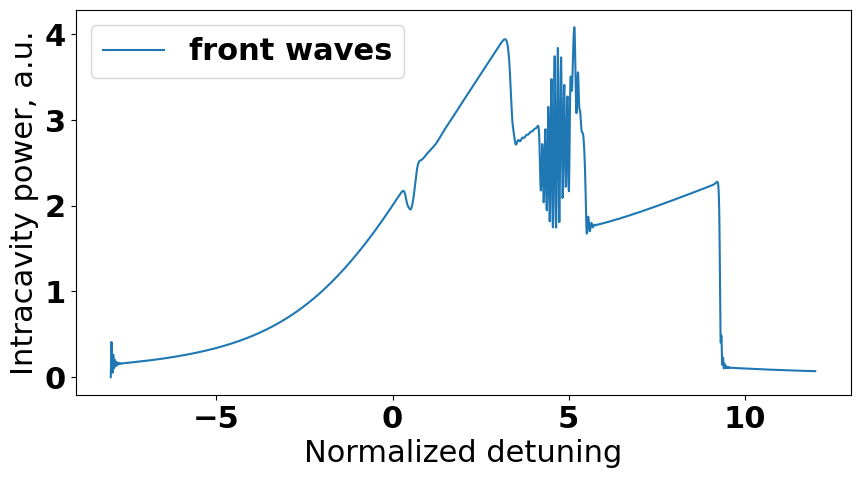

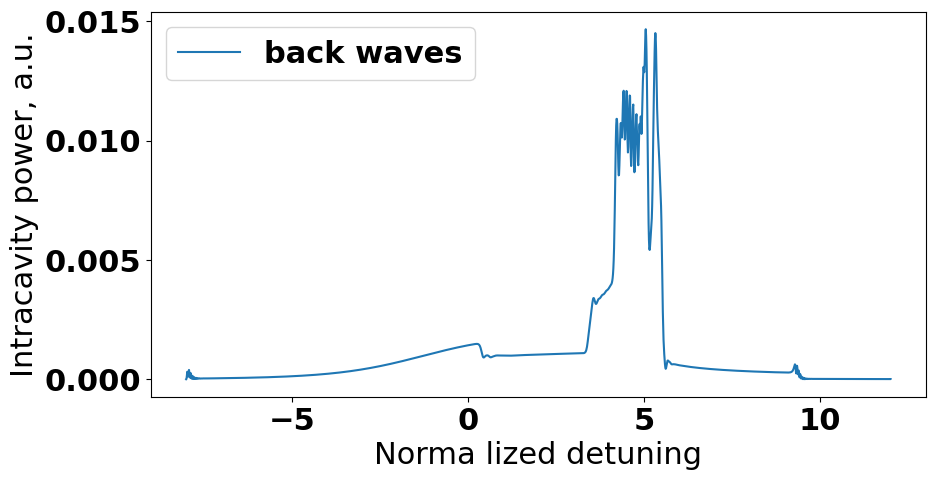

In [6]:
single_ring=Resonator(PhysicalParameters)
#map2d=single_ring.Propagate_SplitStep_back(simulation_parameters, Pump, dt=5e-4)
# map2d=single_ring.Propagate_SAM(simulation_parameters, Pump)
map2d=single_ring.Propagate_SplitStep_back(simulation_parameters, Pump, dt=1e-3)

fig = plt.figure(figsize=(10,5))
plt.xlabel('Normalized detuning')
plt.ylabel('Intracavity power, a.u.')
plt.plot(dOm*2/single_ring.kappa, np.sum(np.abs(map2d[0])**2, axis=1), label="front waves")
#plt.plot(dOm*2/single_ring.kappa, np.sum(np.abs(map2d[1])**2, axis=1), label="back waves")
#plt.savefig('Split_step0.png')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,5))
plt.xlabel('Norma lized detuning')
plt.ylabel('Intracavity power, a.u.')
#plt.plot(dOm*2/single_ring.kappa, np.sum(np.abs(map2d[0])**2, axis=1), label="front waves")
plt.plot(dOm*2/single_ring.kappa, np.sum(np.abs(map2d[1])**2, axis=1), label="back waves")
#plt.savefig('Split_step0.png')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.xlabel('Normalized detuning')
plt.ylabel('Intracavity power, a.u.')
plt.plot(dOm*2/single_ring.kappa, np.abs((map2d[0].T)[1])**2, label="front waves, mu=-1")
plt.plot(dOm*2/single_ring.kappa, np.abs((map2d[1].T)[1])**2, label="back waves, mu=-1")
#plt.plot(dOm*2/single_ring.kappa, np.abs((map2d[0].T)[map2d[0].shape[1] // 2 + 10])**2, label="front waves, mu=2")
#plt.plot(dOm*2/single_ring.kappa, np.sum(np.abs(map2d[1])**2, axis=1), label="back waves")
#plt.savefig('Split_step0.png')
plt.legend()
plt.show()

## Двойная накачка

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import complex_ode, solve_ivp
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from scipy.constants import pi, c, hbar
from matplotlib.widgets import Slider, Button, TextBox
from matplotlib.animation import FuncAnimation
import matplotlib.image as mpimg
from scipy.optimize import curve_fit, root
import time
import torch
from scipy.sparse import block_diag, identity, diags
import scipy.integrate as integrate
from scipy.optimize import fsolve
from tqdm import tqdm as tqdm


class Resonator:
    def __init__(self, resonator_parameters):
        #Initialization of physical parameters
        self.n0=resonator_parameters['n0']
        self.n2=resonator_parameters['n2']
        self.FSR=resonator_parameters['FSR']
        self.w0=resonator_parameters['w0']
        self.width=resonator_parameters['width']
        self.height=resonator_parameters['height']
        self.kappa_0=resonator_parameters['kappa_0']
        self.kappa_ex=resonator_parameters['kappa_ex']
        self.Dint=np.fft.ifftshift(resonator_parameters['Dint'])
        self.n=resonator_parameters['n_pump']
        #Auxiliary physical parameters
        self.Tr=1/self.FSR
        self.Aeff=self.width*self.height
        self.Leff=c/self.n0*self.Tr
        self.Veff=self.Aeff*self.Leff
        self.g0=hbar*self.w0**2*c*self.n2/self.n0**2/self.Veff
        self.gamma=self.n2*self.w0/c/self.Aeff
        self.kappa=self.kappa_0+self.kappa_ex
        self.r_theta=resonator_parameters['thermal_Kerr']
        self.k_theta=resonator_parameters['thermal_time']*self.kappa
        self.N_points=len(self.Dint)
        mu=np.fft.fftshift(np.arange(-self.N_points/2, self.N_points/2))
        self.mu=np.fft.fftshift(np.arange(-self.N_points/2, self.N_points/2))
        def func(x, a, b, c, d):
            return a+x*b+c*x**2/2+d*x**3/6
        popt, pcov=curve_fit(func, mu, self.Dint)
        self.D2=popt[2]
        self.D3=popt[3]
        self.N_micro=resonator_parameters['N_micro']
        self.attempt_num=resonator_parameters['attempt_num']
        self.dzeta=resonator_parameters['dzeta']*2/self.kappa
        self.seed_coup=np.zeros((self.attempt_num, self.N_micro, np.shape(mu)[0]), dtype=np.complex128)
        self.seed_theta=np.zeros((self.attempt_num, self.N_micro), dtype=np.double)
        self.pump_coup=np.zeros_like(self.seed_coup, dtype=np.complex128)
        
        self.seed_coup_single=np.zeros((np.shape(mu)[0]), dtype=np.complex128)
        self.pump_coup_single=np.zeros_like(self.seed_coup_single, dtype=np.complex128)
        self.alpha=resonator_parameters['alpha']
        self.beta=resonator_parameters['beta']
        self.beta_star=np.conjugate(self.beta)
    ### Noise initialisation
    def noise(self, a):
        return a*(2*np.random.rand(self.attempt_num, self.N_micro, self.N_points)-1+1j*(2*np.random.rand(self.attempt_num, self.N_micro, self.N_points)-1))
    
    
    
    def Propagate_SplitStep_dual(self, simulation_parameters, Pump,   Seed=[0], dt=1e-3):
        ### Initialisation parameters for solver
        start_time=time.time()
        T=simulation_parameters['slow_time']
        out_param=simulation_parameters['output']
        detuning1=simulation_parameters['detuning_array1']
        detuning2=simulation_parameters['detuning_array2']
        eps=simulation_parameters['noise_level']

        pump_c=self.pump_coup
        seed_c=self.seed_coup
        seed_c_back=self.seed_coup.copy()
        pump_c[:,:]=Pump*np.sqrt(1./(hbar*self.w0))

        if Seed == [0]:
            seed_c[:,:] = self.seed_level_two_pumps(Pump, detuning1[0], detuning2[0])
            #seed_c[:,:],  seed_c_back[:,:] = self.seed_level_two_pumps_back(Pump, detuning1[0], detuning2[0])
        else:
            seed_c[:,:] = Seed
            #seed_c_back[:,:] = Seed
        ### Renormalization
        T_rn=(self.kappa/2)*T
        f0=pump_c*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        noise_const=self.noise(eps)
        nn=len(detuning1)
        random_attempt=np.random.randint(self.attempt_num)
        t_st=float(T_rn)/len(detuning1)


        sol=np.ndarray(shape=(self.attempt_num, self.N_micro,  self.N_points), dtype='complex128') #define an array to store the data
        sol_eval=np.ndarray(shape=(len(detuning1), self.N_micro,  self.N_points), dtype='complex128') #define an array to store the data
        #sol_back=np.ndarray(shape=(self.attempt_num, self.N_micro,  self.N_points), dtype='complex128')
        #sol_back_eval=np.ndarray(shape=(len(detuning1), self.N_micro,  self.N_points), dtype='complex128')
        sol[:,:,:]=(seed_c)
        #sol_back[:,:,:]=(seed_c_back)

        #print(sol[0,0,:])
        #print(sol_back[0,0,:])
        

        
        ##Calculate effective detuning (zeta in our texts)
        num_det=np.arange(len(detuning1))
        dOm_curr=-(detuning1[num_det]+detuning2[num_det]).reshape(-1,1)/2-(detuning1[num_det]-detuning2[num_det]).reshape(-1,1)/2/self.n*self.mu+self.Dint #detuning value
        
        ### Initial values of amplitudes
        buf=sol.copy()
        #buf_back=sol_back.copy()
        sol_eval[0]=sol[random_attempt]
        #sol_back_eval[0]=sol_back[random_attempt]
        length=len(buf[0,0,:]) ### Number of considered modes in our model        
        K_for=-(1 + 1j * dOm_curr * 2/self.kappa)
        #K_back=-(1+1j*dOm_curr*2/self.kappa)
        #dOm_curr_exp=np.exp(-dt*(1+1j*dOm_curr*2/self.kappa)) #The coefficient in the second solver step
        pumping=f0*length
        #backscattering_coeff=1j*self.beta
        #forw_back_coup=2j*self.alpha
        ### Transform pumps into the time-domain (multiplication by length (N) is necessary to compensate the coefficient from FFT  in first step of solver)
        f=np.fft.ifft(f0,axis=2)*length 
        
        #Start to solve
        for it in tqdm(range(1, len(detuning1))):
            t=0
            buf=sol-noise_const
            #if it==1:
                #continue
            #buf_back=sol_back-noise_const
            #else:
            #    buf_back=sol_back-noise_const
            exp_forward=np.exp(dt * K_for[it])
            
            total_pumping = pumping * (exp_forward - 1) / K_for[it]
#             buf=(pumping+backscattering_coeff*buf_dir_back)*(exp_forward-1)/K_forward + exp_forward*buf_dir

            while t<t_st:
                # First step
                ### Transform amplitudes into the direct-space
                buf_dir=np.fft.ifft(buf, axis=2)
                #buf_dir_back=np.fft.ifft(buf_back, axis=2)

                # Calculation of the first step of solver and transformation back into the frequency-space
                ### IMPORTANT Due to Numpy FFT and IFFT formulation the final value will be multiplied by the coefficient "length" which is the number of modes N in our model.
                # The final solution is Num_of_modes*a. Don't forget divide into the number of modes after solving.
               
                buf_dir=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir)**2))*buf_dir, axis=2)
                #buf_dir_back=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir_back)**2))*buf_dir_back, axis=2)
                
                # Second step
                ### Calculate the second step of split-step method
                #K_backward=forw_back_coup*np.sum(np.abs(buf_dir/length)**2, axis=2)+K_back[it]
                #exp_backward=np.exp(dt*K_backward)
                buf = total_pumping + exp_forward * buf_dir
                #buf_back=(backscattering_coeff*buf_dir)*(exp_backward-1)/K_backward+exp_backward*buf_dir_back                                             
                                                       
                                                     
                t+=dt
                
            sol=buf.copy() ### Current step of all attempts
            sol_eval[it]=sol[random_attempt] ### Time-evolution of one attempt
            #sol_back=buf_back.copy()
            #sol_back_eval[it]=sol_back[random_attempt]
        ### Final solutions
        ### Here we don't forget to divide the solution by the number of modes  (length)!!!
        if out_param=='map':
            return sol/length, sol_eval/length,  detuning1, detuning2 
        elif out_param=='fin_res':
            return sol[-1,:]/length
        else: 
            print('wrong parameter')
            
    def Propagate_SplitStep_dual_single_ring(self, simulation_parameters, Pump,   Seed=[0], dt=1e-3):
        ### Initialisation parameters for solver
        start_time=time.time()
        T=simulation_parameters['slow_time']
        out_param=simulation_parameters['output']
        detuning1=simulation_parameters['detuning_array1']
        detuning2=simulation_parameters['detuning_array2']
        eps = simulation_parameters['noise_level']

        pump_c = self.pump_coup_single
        seed_c = self.seed_coup_single
        pump_c= Pump * np.sqrt(1. / (hbar * self.w0))

        if Seed == [0]:
            seed_c = self.seed_level_two_pumps(Pump, detuning1[0], detuning2[0])
        else:
            seed_c = Seed
            #seed_c_back[:,:] = Seed
        ### Renormalization
        T_rn=(self.kappa/2)*T
        f0=pump_c*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        noise_const=self.noise(eps)
        nn=len(detuning1)
        random_attempt=np.random.randint(self.attempt_num)
        t_st=float(T_rn)/len(detuning1)


        sol = np.ndarray(shape = (self.N_points), dtype='complex128') #define an array to store the 
        sol_eval = np.ndarray(shape = (len(detuning1), self.N_points), dtype='complex128') #define an array to store 
        sol[:] = (seed_c)

        
        ##Calculate effective detuning (zeta in our texts)
        num_det = np.arange(len(detuning1))
        dOm_curr = - (detuning1[num_det] + detuning2[num_det]).reshape(-1,1) / 2 - (detuning1[num_det] - detuning2[num_det]).reshape(-1,1) / 2 / self.n * self.mu + self.Dint #detuning value
        
        ### Initial values of amplitudes
        buf = sol.copy()
        #buf_back=sol_back.copy()
        #sol_eval[0]=sol[random_attempt]
        #sol_back_eval[0]=sol_back[random_attempt]
        length = len(buf) ### Number of considered modes in our model        
        K_for = - (1 + 1j * dOm_curr * 2 / self.kappa)
        #K_back=-(1+1j*dOm_curr*2/self.kappa)
        #dOm_curr_exp=np.exp(-dt*(1+1j*dOm_curr*2/self.kappa)) #The coefficient in the second solver step
        pumping = f0 * length
        #backscattering_coeff=1j*self.beta
        #forw_back_coup=2j*self.alpha
        ### Transform pumps into the time-domain (multiplication by length (N) is necessary to compensate the coefficient from FFT  in first step of solver)
        f = np.fft.ifft(f0) * length 
        
        #Start to solve
        for it in tqdm(range(1, len(detuning1))):
            t = 0
            buf = sol - noise_const
            #if it==1:
                #continue
            #buf_back=sol_back-noise_const
            #else:
            #    buf_back=sol_back-noise_const
            exp_forward = np.exp(dt * K_for[it])
            
            total_pumping = pumping * (exp_forward - 1) / K_for[it]
#             buf=(pumping+backscattering_coeff*buf_dir_back)*(exp_forward-1)/K_forward + exp_forward*buf_dir

            while t < t_st:
                # First step
                ### Transform amplitudes into the direct-space
                buf_dir = np.fft.ifft(buf)
                #buf_dir_back=np.fft.ifft(buf_back, axis=2)

                # Calculation of the first step of solver and transformation back into the frequency-space
                ### IMPORTANT Due to Numpy FFT and IFFT formulation the final value will be multiplied by the coefficient "length" which is the number of modes N in our model.
                # The final solution is Num_of_modes*a. Don't forget divide into the number of modes after solving.
               
                buf_dir = np.fft.fft(np.exp(dt * 1j * np.abs(buf_dir) ** 2) * buf_dir)
                
                #buf_dir_back=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir_back)**2))*buf_dir_back, axis=2)
                
                # Second step
                ### Calculate the second step of split-step method
                #K_backward=forw_back_coup*np.sum(np.abs(buf_dir/length)**2, axis=2)+K_back[it]
                #exp_backward=np.exp(dt*K_backward)
                buf = total_pumping + exp_forward * buf_dir
                #buf_back=(backscattering_coeff*buf_dir)*(exp_backward-1)/K_backward+exp_backward*buf_dir_back                                             
                                                       
                                                     
                t += dt
                
            sol=buf.copy() ### Current step of all attempts
            sol_eval[it]=sol ### Time-evolution of one attempt
            #sol_back=buf_back.copy()
            #sol_back_eval[it]=sol_back[random_attempt]
        ### Final solutions
        ### Here we don't forget to divide the solution by the number of modes  (length)!!!
        if out_param=='map':
            return sol/length, sol_eval/length,  detuning1, detuning2 
        elif out_param=='fin_res':
            return sol[-1,:]/length
        else: 
            print('wrong parameter')
                    
    def Propagate_SplitStep_dual_single_ring_v1(self, simulation_parameters, Pump,   Seed=[0], dt = 1e-3):
        ### Initialisation parameters for solver
        start_time=time.time()
        T=simulation_parameters['slow_time']
        out_param=simulation_parameters['output']
        detuning1=simulation_parameters['detuning_array1']
        detuning2=simulation_parameters['detuning_array2']
        eps = simulation_parameters['noise_level']

        pump_c = self.pump_coup_single
        seed_c = self.seed_coup_single
        pump_c = Pump * np.sqrt(1. / (hbar * self.w0))

        if Seed == [0]:
            seed_c = self.seed_level_two_pumps(Pump, detuning1[0], detuning2[0])
        else:
            seed_c = Seed
            #seed_c_back[:,:] = Seed
        ### Renormalization
        T_rn=(self.kappa/2)*T
        f0=pump_c*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        noise_const=self.noise(eps)
        nn=len(detuning1)
        random_attempt=np.random.randint(self.attempt_num)
        t_st=float(T_rn)/len(detuning1)


        sol = np.ndarray(shape = (self.N_points), dtype='complex128') #define an array to store the 
        sol_eval = np.ndarray(shape = (len(detuning1), self.N_points), dtype='complex128') #define an array to store 
        sol[:] = (seed_c)

        
        ##Calculate effective detuning (zeta in our texts)
        num_det = np.arange(len(detuning1))
        dOm_curr = - (detuning1[num_det] + detuning2[num_det]).reshape(-1,1) / 2 - (detuning1[num_det] - detuning2[num_det]).reshape(-1,1) / 2 / self.n * self.mu + self.Dint #detuning value
        
        ### Initial values of amplitudes
        buf = sol.copy()
        #buf_back=sol_back.copy()
        #sol_eval[0]=sol[random_attempt]
        #sol_back_eval[0]=sol_back[random_attempt]
        length = len(buf) ### Number of considered modes in our model        
        K_for = - (1 + 1j * dOm_curr * 2 / self.kappa)
        #K_back=-(1+1j*dOm_curr*2/self.kappa)
        #dOm_curr_exp=np.exp(-dt*(1+1j*dOm_curr*2/self.kappa)) #The coefficient in the second solver step
        pumping = f0 * length
        #backscattering_coeff=1j*self.beta
        #forw_back_coup=2j*self.alpha
        ### Transform pumps into the time-domain (multiplication by length (N) is necessary to compensate the coefficient from FFT  in first step of solver)
        f = np.fft.ifft(f0) * length 
        
        #Start to solve
        for it in tqdm(range(1, len(detuning1))):
            t = 0
            buf = sol - noise_const
            #if it==1:
                #continue
            #buf_back=sol_back-noise_const
            #else:
            #    buf_back=sol_back-noise_const
            #exp_forward = np.exp(dt * K_for[it])
            exp_forward = np.exp(dt * K_for[it])

            #total_pumping = pumping * (exp_forward - 1) / K_for[it]
#             buf=(pumping+backscattering_coeff*buf_dir_back)*(exp_forward-1)/K_forward + exp_forward*buf_dir

            while t < t_st:
                # First step
                ### Transform amplitudes into the direct-space
                
                buf_dir = np.fft.ifft(buf)
                #buf_dir_back=np.fft.ifft(buf_back, axis=2)

                # Calculation of the first step of solver and transformation back into the frequency-space
                ### IMPORTANT Due to Numpy FFT and IFFT formulation the final value will be multiplied by the coefficient "length" which is the number of modes N in our model.
                # The final solution is Num_of_modes*a. Don't forget divide into the number of modes after solving.
                buf_dir=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir)**2+f/buf_dir))*buf_dir)

                #buf_dir = np.fft.fft(np.exp(dt * 1j * np.abs(buf_dir) ** 2) * buf_dir)
                
                #buf_dir_back=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir_back)**2))*buf_dir_back, axis=2)
                
                # Second step
                ### Calculate the second step of split-step method
                #K_backward=forw_back_coup*np.sum(np.abs(buf_dir/length)**2, axis=2)+K_back[it]
                #exp_backward=np.exp(dt*K_backward)
    #                 buf = total_pumping + exp_forward * buf_dir
                buf=exp_forward*buf_dir

                #buf_back=(backscattering_coeff*buf_dir)*(exp_backward-1)/K_backward+exp_backward*buf_dir_back                                             
                                                       
                                                     
                t += dt
                
            sol=buf.copy() ### Current step of all attempts
            sol_eval[it]=sol ### Time-evolution of one attempt
            #sol_back=buf_back.copy()
            #sol_back_eval[it]=sol_back[random_attempt]
        ### Final solutions
        ### Here we don't forget to divide the solution by the number of modes  (length)!!!
        if out_param=='map':
            return sol/length, sol_eval/length,  detuning1, detuning2 
        elif out_param=='fin_res':
            return sol[-1,:]/length
        else: 
            print('wrong parameter')
            
            
            
    def Propagate_SplitStep_dual_back(self, simulation_parameters, Pump,   Seed=[0], dt=1e-3):
        ### Initialisation parameters for solver
        start_time=time.time()
        T=simulation_parameters['slow_time']
        out_param=simulation_parameters['output']
        detuning1=simulation_parameters['detuning_array1']
        detuning2=simulation_parameters['detuning_array2']
        eps=simulation_parameters['noise_level']

        pump_c=self.pump_coup
        seed_c=self.seed_coup
        seed_c_back=self.seed_coup.copy()
        pump_c[:,:]=Pump*np.sqrt(1./(hbar*self.w0))

        if Seed == [0]:
            #seed_c[:,:],  seed_c_back[:,:] = self.seed_level_two_pumps_SIL(Pump, detuning1[0], detuning2[0])
            seed_c[:,:],  seed_c_back[:,:] = self.seed_level_two_pumps_back(Pump, detuning1[0], detuning2[0])
        else:
            seed_c[:,:] = Seed
            seed_c_back[:,:] = Seed
        ### Renormalization
        T_rn=(self.kappa/2)*T
        f0=pump_c*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        noise_const=self.noise(eps)
        nn=len(detuning1)
        random_attempt=np.random.randint(self.attempt_num)
        t_st=float(T_rn)/len(detuning1)


        sol=np.ndarray(shape=(self.attempt_num, self.N_micro,  self.N_points), dtype='complex128') #define an array to store the data
        sol_eval=np.ndarray(shape=(len(detuning1), self.N_micro,  self.N_points), dtype='complex128') #define an array to store the data
        sol_back=np.ndarray(shape=(self.attempt_num, self.N_micro,  self.N_points), dtype='complex128')
        sol_back_eval=np.ndarray(shape=(len(detuning1), self.N_micro,  self.N_points), dtype='complex128')
        sol[:,:,:]=(seed_c)
        sol_back[:,:,:]=(seed_c_back)

        #print(sol[0,0,:])
        #print(sol_back[0,0,:])
        

        
        ##Calculate effective detuning (zeta in our texts)
        num_det=np.arange(len(detuning1))
        dOm_curr=-(detuning1[num_det]+detuning2[num_det]).reshape(-1,1)/2-(detuning1[num_det]-detuning2[num_det]).reshape(-1,1)/2/self.n*self.mu+self.Dint #detuning value
        
        ### Initial values of amplitudes
        buf=sol.copy()
        buf_back=sol_back.copy()
        sol_eval[0]=sol[random_attempt]
        sol_back_eval[0]=sol_back[random_attempt]
        length=len(buf[0,0,:]) ### Number of considered modes in our model        
        K_for=-(1+1j*dOm_curr*2/self.kappa)
        K_back=-(1+1j*dOm_curr*2/self.kappa)
        #dOm_curr_exp=np.exp(-dt*(1+1j*dOm_curr*2/self.kappa)) #The coefficient in the second solver step
        pumping=f0*length
        backscattering_coeff=1j*self.beta
        forw_back_coup=2j*self.alpha
        ### Transform pumps into the time-domain (multiplication by length (N) is necessary to compensate the coefficient from FFT  in first step of solver)
        f=np.fft.ifft(f0,axis=2)*length 
        
        #Start to solve
        for it in tqdm(range(1, len(detuning1))):
            t=0
            buf=sol-noise_const
            #if it==1:
                #continue
            buf_back=sol_back-noise_const
            #else:
            #    buf_back=sol_back-noise_const
            while t<t_st:
                # First step
                ### Transform amplitudes into the direct-space
                buf_dir=np.fft.ifft(buf, axis=2)
                buf_dir_back=np.fft.ifft(buf_back, axis=2)

                # Calculation of the first step of solver and transformation back into the frequency-space
                ### IMPORTANT Due to Numpy FFT and IFFT formulation the final value will be multiplied by the coefficient "length" which is the number of modes N in our model.
                # The final solution is Num_of_modes*a. Don't forget divide into the number of modes after solving.
               
                buf_dir=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir)**2))*buf_dir, axis=2)
                buf_dir_back=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir_back)**2))*buf_dir_back, axis=2)
                
                # Second step
                ### Calculate the second step of split-step method
                K_forward=forw_back_coup*np.sum(np.abs(buf_dir_back/length)**2, axis=2)+K_for[it]
                K_backward=forw_back_coup*np.sum(np.abs(buf_dir/length)**2, axis=2)+K_back[it]
                exp_forward=np.exp(dt*K_forward)
                exp_backward=np.exp(dt*K_backward)
                buf=(pumping+backscattering_coeff*buf_dir_back)*(exp_forward-1)/K_forward+exp_forward*buf_dir
                buf_back=(backscattering_coeff*buf_dir)*(exp_backward-1)/K_backward+exp_backward*buf_dir_back                                             
                                                       
                                                     
                t+=dt
                
            sol=buf.copy() ### Current step of all attempts
            sol_eval[it]=sol[random_attempt] ### Time-evolution of one attempt
            sol_back=buf_back.copy()
            sol_back_eval[it]=sol_back[random_attempt]
        ### Final solutions
        ### Here we don't forget to divide the solution by the number of modes  (length)!!!
        if out_param=='map':
            return sol/length, sol_eval/length, sol_back/length, sol_back_eval/length, detuning1, detuning2 
        elif out_param=='fin_res':
            return sol[-1,:]/length
        else: 
            print('wrong parameter')
            
            
            
            

   
            
            
            
    def Propagate_SplitStep_dual_back_thermal(self, simulation_parameters, Pump,   Seed=[0], dt=1e-3):
        ### Initialisation parameters for solver
        start_time=time.time()
        T=simulation_parameters['slow_time']
        out_param=simulation_parameters['output']
        detuning1=simulation_parameters['detuning_array1']
        detuning2=simulation_parameters['detuning_array2']
        eps=simulation_parameters['noise_level']

        pump_c=self.pump_coup
        seed_c=self.seed_coup
        seed_c_back=self.seed_coup.copy()
        seed_c_theta=self.seed_theta.copy()
        pump_c[:,:]=Pump*np.sqrt(1./(hbar*self.w0))

        if Seed == [0]:
            seed_c[:,:],  seed_c_back[:,:], seed_c_theta[:,:] = self.seed_level_two_pumps_SIL_thermal(Pump, detuning1[0], detuning2[0])
            #seed_c[:,:],  seed_c_back[:,:], seed_c_theta[:,:] = self.seed_level_two_pumps_back_thermal(Pump, detuning1[0], detuning2[0])
        else:
            seed_c[:,:] = Seed
            seed_c_back[:,:] = Seed
            seed_c_theta[:,:]= Seed
        ### Renormalization
        T_rn=(self.kappa/2)*T
        f0=pump_c*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        noise_const=self.noise(eps)
        nn=len(detuning1)
        random_attempt=np.random.randint(self.attempt_num)
        t_st=float(T_rn)/len(detuning1)


        sol=np.ndarray(shape=(self.attempt_num, self.N_micro,  self.N_points), dtype='complex128') #define an array to store the data
        sol_eval=np.ndarray(shape=(len(detuning1), self.N_micro,  self.N_points), dtype='complex128') #define an array to store the data
        sol_back=np.ndarray(shape=(self.attempt_num, self.N_micro,  self.N_points), dtype='complex128')
        sol_back_eval=np.ndarray(shape=(len(detuning1), self.N_micro,  self.N_points), dtype='complex128')
        sol_theta=np.ndarray(shape=(self.attempt_num, self.N_micro), dtype='double')
        sol_theta_eval=np.ndarray(shape=(len(detuning1), self.N_micro), dtype='double')
        sol[:,:,:]=(seed_c)
        sol_back[:,:,:]=(seed_c_back)
        sol_theta[:,:]=(seed_c_theta)

        print(sol[0,0,:])
        print(sol_back[0,0])
        print(sol_theta[0,0])
        



        ##Calculate effective detuning (zeta in our texts)
        num_det=np.arange(len(detuning1))
        dOm_curr=-(detuning1[num_det]+detuning2[num_det]).reshape(-1,1)/2-(detuning1[num_det]-detuning2[num_det]).reshape(-1,1)/2/self.n*self.mu+self.Dint #detuning value

        ### Initial values of amplitudes
        buf=sol.copy()
        buf_back=sol_back.copy()
        theta=sol_theta.copy()
        sol_eval[0]=sol[random_attempt]
        sol_back_eval[0]=sol_back[random_attempt]
        sol_theta_eval[0]=sol_theta[random_attempt]
        length=len(buf[0,0,:]) ### Number of considered modes in our model        
        K_for=-(1+1j*dOm_curr*2/self.kappa)
        K_back=-(1+1j*dOm_curr*2/self.kappa)
        K_theta=-self.k_theta/self.kappa
        #dOm_curr_exp=np.exp(-dt*(1+1j*dOm_curr*2/self.kappa)) #The coefficient in the second solver step
        pumping=f0*length
        backscattering_coeff=1j*self.beta
        forw_back_coup=2j*self.alpha
        ### Transform pumps into the time-domain (multiplication by length (N) is necessary to compensate the coefficient from FFT  in first step of solver)
        f=np.fft.ifft(f0,axis=2)*length 

        #Start to solve
        for it in tqdm(range(1, len(detuning1))):
            t=0
            buf=sol-noise_const
            #if it==1:
                #continue
            buf_back=sol_back-noise_const
            #else:
            #    buf_back=sol_back-noise_const
            while t<t_st:
                # First step
                ### Transform amplitudes into the direct-space
                buf_dir=np.fft.ifft(buf, axis=2)
                buf_dir_back=np.fft.ifft(buf_back, axis=2)

                # Calculation of the first step of solver and transformation back into the frequency-space
                ### IMPORTANT Due to Numpy FFT and IFFT formulation the final value will be multiplied by the coefficient "length" which is the number of modes N in our model.
                # The final solution is Num_of_modes*a. Don't forget divide into the number of modes after solving.

                buf_dir=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir)**2))*buf_dir, axis=2)
                buf_dir_back=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir_back)**2))*buf_dir_back, axis=2)

                # Second step
                ### Calculate the second step of split-step method
                K_forward=forw_back_coup*np.sum(np.abs(buf_dir_back/length)**2, axis=2)+K_for[it]+1j*theta
                K_backward=forw_back_coup*np.sum(np.abs(buf_dir/length)**2, axis=2)+K_back[it]+1j*theta
                exp_forward=np.exp(dt*K_forward)
                exp_backward=np.exp(dt*K_backward)
                
                A_theta=(-K_theta)*self.r_theta*(np.sum(np.abs(buf_dir/length)**2+np.abs(buf_dir_back/length)**2, axis=2))
                exp_theta=np.exp(dt*K_theta)
                
                theta=A_theta*(exp_theta-1)/K_theta+exp_theta*theta

                buf=(pumping+backscattering_coeff*buf_dir_back)*(exp_forward-1)/K_forward+exp_forward*buf_dir
                buf_back=(backscattering_coeff*buf_dir)*(exp_backward-1)/K_backward+exp_backward*buf_dir_back                                             


                t+=dt

            sol=buf.copy() ### Current step of all attempts
            sol_eval[it]=sol[random_attempt] ### Time-evolution of one attempt
            sol_back=buf_back.copy()
            sol_back_eval[it]=sol_back[random_attempt]
            sol_theta_eval[it]=theta[random_attempt]
        ### Final solutions
        ### Here we don't forget to divide the solution by the number of modes  (length)!!!
        if out_param=='map':
            return sol/length, sol_eval/length,sol_back/length, sol_back_eval/length, detuning1, detuning2,theta, sol_theta_eval
        elif out_param=='fin_res':
            return sol[-1,:]/length
        else: 
            print('wrong parameter')    
            
            
            

    def seed_level_two_pumps(self,pump, detuning1, detuning2):
        f_norm=np.real(pump)*np.sqrt(1./(hbar*self.w0))*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        detuning_1_norm=2/self.kappa*(-detuning1)
        detuning_2_norm=2/self.kappa*(-detuning2)
        def myFunction(z):
            x_p = z[0]
            p_p = z[1]
            x_m = z[2]
            p_m = z[3]


            F = np.empty((4))
            F[0] = x_p-detuning_1_norm*p_p+(x_p**2+p_p**2+2*(x_m**2+p_m**2))*p_p-f_norm[self.n]
            F[1] = p_p+x_p*detuning_1_norm-(x_p**2+p_p**2+2*(x_m**2+p_m**2))*x_p
            F[2] = x_m-detuning_2_norm*p_m+(x_m**2+p_m**2+2*(x_p**2+p_p**2))*p_m-f_norm[-self.n]
            F[3] = p_m+x_m*detuning_2_norm-(x_m**2+p_m**2+2*(x_p**2+p_p**2))*x_m
            return F

        zGuess = np.array([0,0,0,0])
        sol_init=fsolve(myFunction,zGuess)
        res_seed=np.zeros_like(f_norm, dtype='complex128')
        res_seed[self.n]=(sol_init[0]+1j*sol_init[1])
        res_seed[-self.n]=(sol_init[2]+1j*sol_init[3])
        return res_seed
    
    
    
    def seed_level_two_pumps_back(self,pump, detuning1, detuning2):
        f_norm=np.real(pump)*np.sqrt(1./(hbar*self.w0))*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        detuning_1_norm=2/self.kappa*(-detuning1)
        detuning_2_norm=2/self.kappa*(-detuning2)
        def func(x):
            return [-x[0] - 1.j*detuning_1_norm*x[0] + 1.j*(2*np.abs(x[1])**2+np.abs(x[0])**2+2*self.alpha*(np.abs(x[2])**2+np.abs(x[3])**2))*x[0]+f_norm[self.n]+1.j*self.beta*x[2],
                    
                    -x[1] - 1.j*detuning_2_norm*x[1] + 1.j*(2*np.abs(x[0])**2+np.abs(x[1])**2+2*self.alpha*(np.abs(x[2])**2+np.abs(x[3])**2))*x[1]+f_norm[-self.n]+1.j*self.beta*x[3],
                    
                    -x[2] - 1.j*detuning_1_norm*x[2] + 1.j*(2*np.abs(x[3])**2+np.abs(x[2])**2+2*self.alpha*(np.abs(x[0])**2+np.abs(x[1])**2))*x[2]+1.j*self.beta*x[0],
                    
                    -x[3] - 1.j*detuning_2_norm*x[3] + 1.j*(2*np.abs(x[2])**2+np.abs(x[3])**2+2*self.alpha*(np.abs(x[0])**2+np.abs(x[1])**2))*x[3]+1.j*self.beta*x[1]]
        

        roots = root(func, [1. + 1.j, 1. + 1.j, 1.+1.j, 1.+1.j], method='broyden1').x
        res_seed=np.zeros_like(f_norm, dtype='complex128')
        res_seed_back=np.zeros_like(f_norm, dtype='complex128')

        res_seed[self.n]=roots[0]
        res_seed[-self.n]=roots[1]
        res_seed_back[self.n]=roots[2]
        res_seed_back[-self.n]=roots[3]
        return res_seed, res_seed_back
    
    def seed_level_two_pumps_back_thermal(self,pump, detuning1, detuning2):
        f_norm=np.real(pump)*np.sqrt(1./(hbar*self.w0))*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        detuning_1_norm=2/self.kappa*(-detuning1)
        detuning_2_norm=2/self.kappa*(-detuning2)
        def func(x):
            return [-x[0] - 1.j*detuning_1_norm*x[0]+1.j*x[4] + 1.j*(2*np.abs(x[1])**2+np.abs(x[0])**2+2*self.alpha*(np.abs(x[2])**2+np.abs(x[3])**2))*x[0]+f_norm[self.n]+1.j*self.beta*x[2],
                    
                    -x[1] - 1.j*detuning_2_norm*x[1]+1.j*x[4] + 1.j*(2*np.abs(x[0])**2+np.abs(x[1])**2+2*self.alpha*(np.abs(x[2])**2+np.abs(x[3])**2))*x[1]+f_norm[-self.n]+1.j*self.beta*x[3],
                    
                    -x[2] - 1.j*detuning_1_norm*x[2]+1.j*x[4] + 1.j*(2*np.abs(x[3])**2+np.abs(x[2])**2+2*self.alpha*(np.abs(x[0])**2+np.abs(x[1])**2))*x[2]+1.j*self.beta*x[0],
                    
                    -x[3] - 1.j*detuning_2_norm*x[3]+1.j*x[4] + 1.j*(2*np.abs(x[2])**2+np.abs(x[3])**2+2*self.alpha*(np.abs(x[0])**2+np.abs(x[1])**2))*x[3]+1.j*self.beta*x[1],
                   self.k_theta/self.kappa*(self.r_theta*(np.abs(x[0])**2+np.abs(x[1])**2+np.abs(x[2])**2+np.abs(x[3])**2)-x[4])]
        

        roots = root(func, [1. + 1.j, 1. + 1.j, 1.+1.j, 1.+1.j, 1.], method='broyden1').x
        res_seed=np.zeros_like(f_norm, dtype='complex128')
        res_seed_back=np.zeros_like(f_norm, dtype='complex128')

        res_seed[self.n]=roots[0]
        res_seed[-self.n]=roots[1]
        res_seed_back[self.n]=roots[2]
        res_seed_back[-self.n]=roots[3]
        return res_seed, res_seed_back, roots[4]
    
    def seed_level_two_pumps_SIL(self,pump, detuning1, detuning2):
        f_norm=np.real(pump)*np.sqrt(1./(hbar*self.w0))*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        detuning_1_norm=2/self.kappa*(-detuning1)
        detuning_2_norm=2/self.kappa*(-detuning2)
        def myFunction(z):
            x_p = z[0]
            p_p = z[1]
            x_m = z[2]
            p_m = z[3]
            x_back_p=z[4]
            p_back_p=z[5]
            x_back_m=z[6]
            p_back_m=z[7]

            F = np.empty((8))
            F[0] = x_p-detuning_1_norm*p_p+(x_p**2+p_p**2+2*(x_m**2+p_m**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*p_p-f_norm[self.n]+self.beta*p_back_p
            
            F[1] = p_p+x_p*detuning_1_norm-(x_p**2+p_p**2+2*(x_m**2+p_m**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*x_p-self.beta*x_back_p
            
            F[2] = x_m-detuning_2_norm*p_m+(x_m**2+p_m**2+2*(x_p**2+p_p**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*p_m-f_norm[-self.n]+self.beta*p_back_m
            
            F[3] = p_m+x_m*detuning_2_norm-(x_m**2+p_m**2+2*(x_p**2+p_p**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*x_m-self.beta*x_back_m
            
            
            F[4] = x_back_p-detuning_1_norm*p_back_p+(x_back_p**2+p_back_p**2+2*(x_back_m**2+p_back_m**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*p_back_p+self.beta*p_p
            
            F[5] = p_back_p+x_back_p*detuning_1_norm-(x_back_p**2+p_back_p**2+2*(x_back_m**2+p_back_m**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*x_back_p-self.beta*x_p
            
            F[6] = x_back_m-detuning_2_norm*p_back_m+(x_back_m**2+p_back_m**2+2*(x_back_p**2+p_back_p**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*p_back_m+self.beta*p_m
            
            F[7] = p_back_m+x_back_m*detuning_2_norm-(x_back_m**2+p_back_m**2+2*(x_back_p**2+p_back_p**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*x_back_m-self.beta*x_m
            
            
            return F

        zGuess = np.array([0,0,0,0,0,0,0,0])
        sol_init=fsolve(myFunction,zGuess)
        res_seed=np.zeros_like(f_norm, dtype='complex128')
        res_seed[self.n]=(sol_init[0]+1j*sol_init[1])
        res_seed[-self.n]=(sol_init[2]+1j*sol_init[3])
        res_seed_back=np.zeros_like(f_norm, dtype='complex128')
        res_seed_back[self.n]=(sol_init[4]+1j*sol_init[5])
        res_seed_back[-self.n]=(sol_init[6]+1j*sol_init[7])
        return res_seed, res_seed_back
    
    
    
    
    def seed_level_two_pumps_SIL_thermal(self,pump, detuning1, detuning2):
        f_norm=np.real(pump)*np.sqrt(1./(hbar*self.w0))*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        detuning_1_norm=2/self.kappa*(-detuning1)
        detuning_2_norm=2/self.kappa*(-detuning2)
        def myFunction(z):
            x_p = z[0]
            p_p = z[1]
            x_m = z[2]
            p_m = z[3]
            x_back_p=z[4]
            p_back_p=z[5]
            x_back_m=z[6]
            p_back_m=z[7]
            theta=z[8]
            
            F = np.empty((9))
            F[0] = x_p-detuning_1_norm*p_p+(x_p**2+p_p**2+2*(x_m**2+p_m**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*p_p-f_norm[self.n]+self.beta*p_back_p-theta*p_p
            
            F[1] = p_p+x_p*detuning_1_norm-(x_p**2+p_p**2+2*(x_m**2+p_m**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*x_p-self.beta*x_back_p+theta*x_p
            
            F[2] = x_m-detuning_2_norm*p_m+(x_m**2+p_m**2+2*(x_p**2+p_p**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*p_m-f_norm[-self.n]+self.beta*p_back_m-theta*p_m
            
            F[3] = p_m+x_m*detuning_2_norm-(x_m**2+p_m**2+2*(x_p**2+p_p**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*x_m-self.beta*x_back_m+theta*x_m
            
            
            F[4] = x_back_p-detuning_1_norm*p_back_p+(x_back_p**2+p_back_p**2+2*(x_back_m**2+p_back_m**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*p_back_p+self.beta*p_p-theta*p_back_p
            
            F[5] = p_back_p+x_back_p*detuning_1_norm-(x_back_p**2+p_back_p**2+2*(x_back_m**2+p_back_m**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*x_back_p-self.beta*x_p+theta*x_back_p
            
            F[6] = x_back_m-detuning_2_norm*p_back_m+(x_back_m**2+p_back_m**2+2*(x_back_p**2+p_back_p**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*p_back_m+self.beta*p_m-theta*p_back_p
            
            F[7] = p_back_m+x_back_m*detuning_2_norm-(x_back_m**2+p_back_m**2+2*(x_back_p**2+p_back_p**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*x_back_m-self.beta*x_m+theta*x_back_m
            
            F[8] = self.k_theta/self.kappa*(self.r_theta*(x_p**2+p_p**2+x_m**2+p_m**2+x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2)-theta)
            
            return F

        zGuess = np.array([0,0,0,0,0,0,0,0,0])
        sol_init=fsolve(myFunction,zGuess)
        res_seed=np.zeros_like(f_norm, dtype='complex128')
        res_seed[self.n]=(sol_init[0]+1j*sol_init[1])
        res_seed[-self.n]=(sol_init[2]+1j*sol_init[3])
        res_seed_back=np.zeros_like(f_norm, dtype='complex128')
        res_seed_back[self.n]=(sol_init[4]+1j*sol_init[5])
        res_seed_back[-self.n]=(sol_init[6]+1j*sol_init[7])
        res_seed_theta=sol_init[8]
        return res_seed, res_seed_back, res_seed_theta
    





## Параметры для двойной накачки

In [2]:
N_modes = 2**9     ### Number of modes in model
D2 = 2 * np.pi * 14e5 #- beta2*(2*np.pi*FSR)**2/beta1; beta2 = - 105e-27 #s^2/m; beta1 = 7.09e-9
FSR = 1000e9       ### c / n0 / 2 / pi / R; R = 100e-6 ring radius ?

n = 1              # n_pump

resonator_parameters = {'n0'          : 1.83, 
                        'n2'          : 2.4e-19, ### m^2/W #c*wdth*height/(2*np.pi*c/wavelength)
                        'FSR'         : FSR, #Hz
                        'w0'          : 2*pi * (c / 1547.16e-9), # wavelength=1547.16e-9, 2*np.pi*(c/wavelength)
                        'width'       : 1.5e-6, 
                        'height'      : 0.8e-6, 
                        'kappa_0'     : 2*pi * 188e6, 
                        'kappa_ex'    : 2*pi * 269e6,
                        'Dint'        : (np.arange(-N_modes/2, N_modes/2)**2 - n**2)* D2 / 2, #(mu**2-n**2)*D2/2
                        'alpha'       : 0, #1.0,
                        'beta'        : 0, #0.11,
                        'thermal_time': 0, # 1e-3 ##0.01,
                        'thermal_Kerr': 0, #0.1 ##1,
                        'n_pump'      : n, #
                        'N_micro'     : 1,
                        'attempt_num' : 1,
                        'dzeta'        : 0.5e-5 * 2*pi * FSR}

ring = Resonator(resonator_parameters)

N_detuning = 6000
ramp_stop = 0.99

delta_f = 0
dNu_ini_pl =  1e9  # w_p - w_0
dNu_end_pl = -1e9

dNu_ini_min =  1e9 #- delta_f * 1e9 #-0e9
dNu_end_min = -1e9 #- delta_f * 1e9 #-0.65e9

dOm1 = 2*pi * np.concatenate([np.linspace(dNu_ini_pl, dNu_end_pl, int(N_detuning * ramp_stop)), 
                              dNu_end_pl * np.ones(int(np.round(N_detuning * (1 - ramp_stop))))])
dOm2 = 2*pi * np.concatenate([np.linspace(dNu_ini_min, dNu_end_min, int(N_detuning * ramp_stop)), 
                              dNu_end_min * np.ones(int(np.round(N_detuning * (1 - ramp_stop))))])

J = np.array([0]) # ??? coupling_matrix

simulation_parameters = {'slow_time'         : 4e-6, 
                         'detuning_array1'   : dOm1,
                         'detuning_array2'   : dOm2,
                         'noise_level'       : 1e-6, 
                         'output'            : 'map', 
                         'absolute_tolerance': 1e-8, 
                         'relative_tolerance': 1e-8, 
                         'max_internal_steps': 2000,
                         'coupling_matrix'   : J}

Pump = np.zeros(N_modes, dtype='complex128')

P_pl  = 0.015
P_min = 0.015

Pump[n] = np.sqrt(P_pl)
Pump[-n] = np.sqrt(P_min)

In [3]:
dOm1[1] - dOm1[0]

-2115906.82174778

In [11]:
map2d = Resonator.Propagate_SplitStep_dual_back(ring, simulation_parameters, Pump, dt = 5e-3)

100%|██████████████████████████████████████████████████████████████████████████████| 5999/5999 [08:37<00:00, 11.59it/s]


In [36]:
map2d[1].shape

(6000, 1, 512)

In [9]:
# map2d

#Here is forw, forw_eval, back, back_eval and 2 deturning. Important for as is forward_eval[-1] ans back_eval[-1]

np.sum(np.abs(map2d[1])**2, axis = 1).T[0].shape
print(map2d[1][-1])

[[-5.54039860e-06+1.59795978e-05j  2.27621922e-01-1.40593677e-01j
   1.02933199e-05+7.65696244e-05j  8.76908950e-02+4.73861797e-02j
   7.62523282e-05+6.10642494e-05j -3.75664992e-02-2.19280805e-02j
   1.50442007e-04-5.75009187e-05j -1.37239164e-01-7.85531650e-02j
   1.64437499e-04-2.13559588e-04j -1.64415967e-01-9.24015676e-02j
   7.91915938e-05-2.90598639e-04j -1.11022656e-01-6.10902117e-02j
  -7.68494839e-05-2.06584501e-04j -1.02532071e-02-5.58554540e-03j
  -2.18827148e-04+1.98506894e-05j  8.42858427e-02+4.40006834e-02j
  -2.59080395e-04+2.71486687e-04j  1.27985831e-01+6.51391893e-02j
  -1.65145850e-04+4.02503318e-04j  1.06500118e-01+5.28003126e-02j
   1.75648104e-05+3.29293242e-04j  3.88489262e-02+1.87407176e-02j
   1.92135497e-04+8.29774080e-05j -3.65916823e-02-1.73051165e-02j
   2.66776593e-04-2.07907932e-04j -8.35141458e-02-3.84911371e-02j
   2.05967271e-04-3.91218534e-04j -8.47002216e-02-3.81237915e-02j
   4.69988465e-05-3.75497800e-04j -4.70718634e-02-2.06841136e-02j
  -1.24409

Text(0, 0.5, 'Intracavity power (a.u.)')

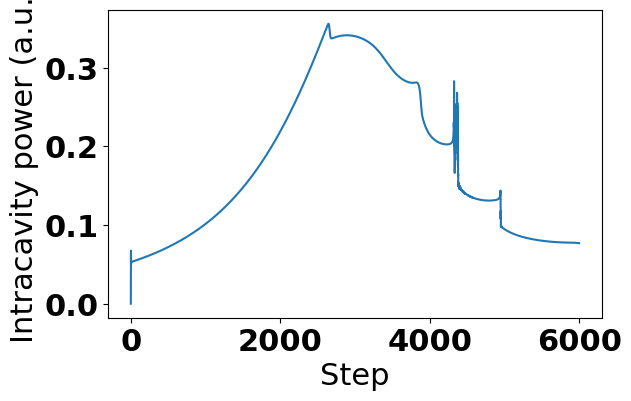

In [42]:


fig = plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(np.arange(len(dOm1)), np.sum(np.abs(map2d[1])**2, axis = 1).T[1])
plt.xlabel('Step')
plt.ylabel('Intracavity power (a.u.)')
#plt.subplot(1,2,2)
#plt.plot(dOm1/k_2, np.abs(map2d[:,0])**2 / (2 * ring.g0 / ring.kappa), label = 'a0')
#plt.xlabel('N. detuning')
#plt.ylabel('Intracavity power')
#plt.legend()

In [75]:
numb = 3000
sol1 = map2d[0][0]
line_width = 1
font_size = 20
font_weight = 'bold'


power_modes=np.abs(sol1)**2
pump_init = np.zeros_like(power_modes)
pump_init[:, -n] = P_min
pump_init[:, n] = P_pl



plt.figure(figsize=(7, 5))
for i in range(-N_modes//2 + 1, N_modes//2 - 1):
    coeff = ring.kappa_ex / FSR / 2 / np.pi 
    to_power = ring.kappa/2/ring.g0*FSR
    power_min = np.min(10*np.log10(np.abs(np.sqrt(pump_init[numb, :]/hbar/single_ring.w0) - np.sqrt(coeff) * (sol1)[numb, :] * np.sqrt(to_power))**2 * hbar * single_ring.w0 * 1e3))
    power_max = 10*np.log10(np.abs(np.sqrt(pump_init[numb, i]/hbar/single_ring.w0) - np.sqrt(coeff) * (sol1)[numb, i] * np.sqrt(to_power))**2 * hbar * single_ring.w0 * 1e3)
    plt.vlines(i, power_min, power_max, linewidth = 1)
plt.title('Output spectrum', fontsize = font_size, fontweight = font_weight)
plt.xlabel('Mode number', fontsize = font_size, fontweight = font_weight)
plt.ylabel('Power, dBm', fontsize = font_size, fontweight = font_weight)
plt.xticks(fontsize = font_size, fontweight = font_weight)
plt.yticks(fontsize = font_size, fontweight = font_weight)

IndexError: index 3000 is out of bounds for axis 0 with size 1

<Figure size 700x500 with 0 Axes>

C:\Users\Дарья\AppData\Local\Temp\ipykernel_1064\1763226528.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(map2d[-2], np.log(abs(map2d[1].T[0][0])))


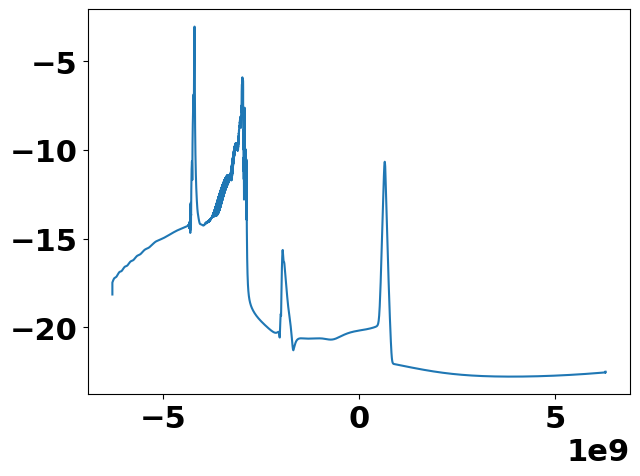

In [71]:
fig = plt.figure(figsize=(7, 5))
plt.plot(map2d[-2], np.log(abs(map2d[1].T[0][0])))

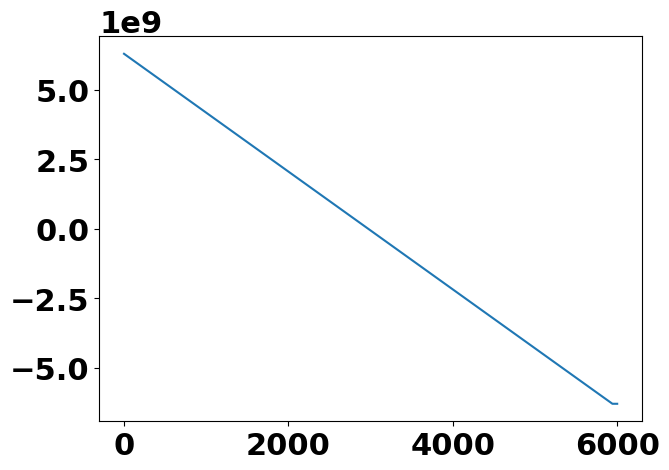

In [8]:
fig = plt.figure(figsize=(7, 5))
plt.plot(dOm1)

In [ ]:
list(dOm1).index(-6283185307.179586)

# Проверка гипотезы двойной накачки!

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import complex_ode, solve_ivp
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from scipy.constants import pi, c, hbar
from matplotlib.widgets import Slider, Button, TextBox
from matplotlib.animation import FuncAnimation
import matplotlib.image as mpimg
from scipy.optimize import curve_fit, root
import time
import torch
from scipy.sparse import block_diag, identity, diags
import scipy.integrate as integrate
from scipy.optimize import fsolve
from tqdm import tqdm as tqdm


class Resonator:
    def __init__(self, resonator_parameters):
        #Initialization of physical parameters
        self.n0=resonator_parameters['n0']
        self.n2=resonator_parameters['n2']
        self.FSR=resonator_parameters['FSR']
        self.w0=resonator_parameters['w0']
        self.width=resonator_parameters['width']
        self.height=resonator_parameters['height']
        self.kappa_0=resonator_parameters['kappa_0']
        self.kappa_ex=resonator_parameters['kappa_ex']
        self.Dint=np.fft.ifftshift(resonator_parameters['Dint'])
        self.n=resonator_parameters['n_pump']
        #Auxiliary physical parameters
        self.Tr=1/self.FSR
        self.Aeff=self.width*self.height
        self.Leff=c/self.n0*self.Tr
        self.Veff=self.Aeff*self.Leff
        self.g0=hbar*self.w0**2*c*self.n2/self.n0**2/self.Veff
        self.gamma=self.n2*self.w0/c/self.Aeff
        self.kappa=self.kappa_0+self.kappa_ex
        self.r_theta=resonator_parameters['thermal_Kerr']
        self.k_theta=resonator_parameters['thermal_time']*self.kappa
        self.N_points=len(self.Dint)
        mu=np.fft.fftshift(np.arange(-self.N_points/2, self.N_points/2))
        self.mu=np.fft.fftshift(np.arange(-self.N_points/2, self.N_points/2))
        def func(x, a, b, c, d):
            return a+x*b+c*x**2/2+d*x**3/6
        popt, pcov=curve_fit(func, mu, self.Dint)
        self.D2=popt[2]
        self.D3=popt[3]
        self.N_micro=resonator_parameters['N_micro']
        self.attempt_num=resonator_parameters['attempt_num']
        self.dzeta=resonator_parameters['dzeta']*2/self.kappa
        self.seed_coup=np.zeros((self.attempt_num, self.N_micro, np.shape(mu)[0]), dtype=np.complex128)
        self.seed_theta=np.zeros((self.attempt_num, self.N_micro), dtype=np.double)
        self.pump_coup=np.zeros_like(self.seed_coup, dtype=np.complex128)
        
        self.seed_coup_single=np.zeros((np.shape(mu)[0]), dtype=np.complex128)
        self.pump_coup_single=np.zeros_like(self.seed_coup_single, dtype=np.complex128)
        self.alpha=resonator_parameters['alpha']
        self.beta=resonator_parameters['beta']
        self.beta_star=np.conjugate(self.beta)
    ### Noise initialisation
    def noise(self, a):
        return a*(2*np.random.rand(self.attempt_num, self.N_micro, self.N_points)-1+1j*(2*np.random.rand(self.attempt_num, self.N_micro, self.N_points)-1))
    
    
    
    def Propagate_SplitStep_dual(self, simulation_parameters, Pump,   Seed=[0], dt=1e-3):
        ### Initialisation parameters for solver
        start_time=time.time()
        T=simulation_parameters['slow_time']
        out_param=simulation_parameters['output']
        detuning1=simulation_parameters['detuning_array1']
        detuning2=simulation_parameters['detuning_array2']
        eps=simulation_parameters['noise_level']

        pump_c=self.pump_coup
        seed_c=self.seed_coup
        seed_c_back=self.seed_coup.copy()
        pump_c[:,:]=Pump*np.sqrt(1./(hbar*self.w0))

        if Seed == [0]:
            seed_c[:,:] = self.seed_level_two_pumps(Pump, detuning1[0], detuning2[0])
            #seed_c[:,:],  seed_c_back[:,:] = self.seed_level_two_pumps_back(Pump, detuning1[0], detuning2[0])
        else:
            seed_c[:,:] = Seed
            #seed_c_back[:,:] = Seed
        ### Renormalization
        T_rn=(self.kappa/2)*T
        f0=pump_c*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        noise_const=self.noise(eps)
        nn=len(detuning1)
        random_attempt=np.random.randint(self.attempt_num)
        t_st=float(T_rn)/len(detuning1)


        sol=np.ndarray(shape=(self.attempt_num, self.N_micro,  self.N_points), dtype='complex128') #define an array to store the data
        sol_eval=np.ndarray(shape=(len(detuning1), self.N_micro,  self.N_points), dtype='complex128') #define an array to store the data
        #sol_back=np.ndarray(shape=(self.attempt_num, self.N_micro,  self.N_points), dtype='complex128')
        #sol_back_eval=np.ndarray(shape=(len(detuning1), self.N_micro,  self.N_points), dtype='complex128')
        sol[:,:,:]=(seed_c)
        #sol_back[:,:,:]=(seed_c_back)

        #print(sol[0,0,:])
        #print(sol_back[0,0,:])
        

        
        ##Calculate effective detuning (zeta in our texts)
        num_det=np.arange(len(detuning1))
        dOm_curr=-(detuning1[num_det]+detuning2[num_det]).reshape(-1,1)/2-(detuning1[num_det]-detuning2[num_det]).reshape(-1,1)/2/self.n*self.mu+self.Dint #detuning value
        
        ### Initial values of amplitudes
        buf=sol.copy()
        #buf_back=sol_back.copy()
        sol_eval[0]=sol[random_attempt]
        #sol_back_eval[0]=sol_back[random_attempt]
        length=len(buf[0,0,:]) ### Number of considered modes in our model        
        K_for=-(1 + 1j * dOm_curr * 2/self.kappa)
        #K_back=-(1+1j*dOm_curr*2/self.kappa)
        #dOm_curr_exp=np.exp(-dt*(1+1j*dOm_curr*2/self.kappa)) #The coefficient in the second solver step
        pumping=f0*length
        #backscattering_coeff=1j*self.beta
        #forw_back_coup=2j*self.alpha
        ### Transform pumps into the time-domain (multiplication by length (N) is necessary to compensate the coefficient from FFT  in first step of solver)
        f=np.fft.ifft(f0,axis=2)*length 
        
        #Start to solve
        for it in tqdm(range(1, len(detuning1))):
            t=0
            buf=sol-noise_const
            #if it==1:
                #continue
            #buf_back=sol_back-noise_const
            #else:
            #    buf_back=sol_back-noise_const
            exp_forward=np.exp(dt * K_for[it])
            
            total_pumping = pumping * (exp_forward - 1) / K_for[it]
#             buf=(pumping+backscattering_coeff*buf_dir_back)*(exp_forward-1)/K_forward + exp_forward*buf_dir

            while t<t_st:
                # First step
                ### Transform amplitudes into the direct-space
                buf_dir=np.fft.ifft(buf, axis=2)
                #buf_dir_back=np.fft.ifft(buf_back, axis=2)

                # Calculation of the first step of solver and transformation back into the frequency-space
                ### IMPORTANT Due to Numpy FFT and IFFT formulation the final value will be multiplied by the coefficient "length" which is the number of modes N in our model.
                # The final solution is Num_of_modes*a. Don't forget divide into the number of modes after solving.
               
                buf_dir=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir)**2))*buf_dir, axis=2)
                #buf_dir_back=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir_back)**2))*buf_dir_back, axis=2)
                
                # Second step
                ### Calculate the second step of split-step method
                #K_backward=forw_back_coup*np.sum(np.abs(buf_dir/length)**2, axis=2)+K_back[it]
                #exp_backward=np.exp(dt*K_backward)
                buf = total_pumping + exp_forward * buf_dir
                #buf_back=(backscattering_coeff*buf_dir)*(exp_backward-1)/K_backward+exp_backward*buf_dir_back                                             
                                                       
                                                     
                t+=dt
                
            sol=buf.copy() ### Current step of all attempts
            sol_eval[it]=sol[random_attempt] ### Time-evolution of one attempt
            #sol_back=buf_back.copy()
            #sol_back_eval[it]=sol_back[random_attempt]
        ### Final solutions
        ### Here we don't forget to divide the solution by the number of modes  (length)!!!
        if out_param=='map':
            return sol/length, sol_eval/length,  detuning1, detuning2 
        elif out_param=='fin_res':
            return sol[-1,:]/length
        else: 
            print('wrong parameter')
            
    def Propagate_SplitStep_dual_single_ring(self, simulation_parameters, Pump,   Seed=[0], dt=1e-3):
        ### Initialisation parameters for solver
        start_time=time.time()
        T=simulation_parameters['slow_time']
        out_param=simulation_parameters['output']
        detuning1=simulation_parameters['detuning_array1']
        detuning2=simulation_parameters['detuning_array2']
        eps = simulation_parameters['noise_level']

        pump_c = self.pump_coup_single
        seed_c = self.seed_coup_single
        pump_c= Pump * np.sqrt(1. / (hbar * self.w0))

        if Seed == [0]:
            seed_c = self.seed_level_two_pumps(Pump, detuning1[0], detuning2[0])
        else:
            seed_c = Seed
            #seed_c_back[:,:] = Seed
        ### Renormalization
        T_rn=(self.kappa/2)*T
        f0=pump_c*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        noise_const=self.noise(eps)
        nn=len(detuning1)
        random_attempt=np.random.randint(self.attempt_num)
        t_st=float(T_rn)/len(detuning1)


        sol = np.ndarray(shape = (self.N_points), dtype='complex128') #define an array to store the 
        sol_eval = np.ndarray(shape = (len(detuning1), self.N_points), dtype='complex128') #define an array to store 
        sol[:] = (seed_c)

        
        ##Calculate effective detuning (zeta in our texts)
        num_det = np.arange(len(detuning1))
        dOm_curr = - (detuning1[num_det] + detuning2[num_det]).reshape(-1,1) / 2 - (detuning1[num_det] - detuning2[num_det]).reshape(-1,1) / 2 / self.n * self.mu + self.Dint #detuning value
        
        ### Initial values of amplitudes
        buf = sol.copy()
        #buf_back=sol_back.copy()
        #sol_eval[0]=sol[random_attempt]
        #sol_back_eval[0]=sol_back[random_attempt]
        length = len(buf) ### Number of considered modes in our model        
        K_for = - (1 + 1j * dOm_curr * 2 / self.kappa)
        #K_back=-(1+1j*dOm_curr*2/self.kappa)
        #dOm_curr_exp=np.exp(-dt*(1+1j*dOm_curr*2/self.kappa)) #The coefficient in the second solver step
        pumping = f0 * length
        #backscattering_coeff=1j*self.beta
        #forw_back_coup=2j*self.alpha
        ### Transform pumps into the time-domain (multiplication by length (N) is necessary to compensate the coefficient from FFT  in first step of solver)
        f = np.fft.ifft(f0) * length 
        
        #Start to solve
        for it in tqdm(range(1, len(detuning1))):
            t = 0
            buf = sol - noise_const
            #if it==1:
                #continue
            #buf_back=sol_back-noise_const
            #else:
            #    buf_back=sol_back-noise_const
            exp_forward = np.exp(dt * K_for[it])
            
            total_pumping = pumping * (exp_forward - 1) / K_for[it]
#             buf=(pumping+backscattering_coeff*buf_dir_back)*(exp_forward-1)/K_forward + exp_forward*buf_dir

            while t < t_st:
                # First step
                ### Transform amplitudes into the direct-space
                buf_dir = np.fft.ifft(buf)
                #buf_dir_back=np.fft.ifft(buf_back, axis=2)

                # Calculation of the first step of solver and transformation back into the frequency-space
                ### IMPORTANT Due to Numpy FFT and IFFT formulation the final value will be multiplied by the coefficient "length" which is the number of modes N in our model.
                # The final solution is Num_of_modes*a. Don't forget divide into the number of modes after solving.
               
                buf_dir = np.fft.fft(np.exp(dt * 1j * np.abs(buf_dir) ** 2) * buf_dir)
                
                #buf_dir_back=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir_back)**2))*buf_dir_back, axis=2)
                
                # Second step
                ### Calculate the second step of split-step method
                #K_backward=forw_back_coup*np.sum(np.abs(buf_dir/length)**2, axis=2)+K_back[it]
                #exp_backward=np.exp(dt*K_backward)
                buf = total_pumping + exp_forward * buf_dir
                #buf_back=(backscattering_coeff*buf_dir)*(exp_backward-1)/K_backward+exp_backward*buf_dir_back                                             
                                                       
                                                     
                t += dt
                
            sol=buf.copy() ### Current step of all attempts
            sol_eval[it]=sol ### Time-evolution of one attempt
            #sol_back=buf_back.copy()
            #sol_back_eval[it]=sol_back[random_attempt]
        ### Final solutions
        ### Here we don't forget to divide the solution by the number of modes  (length)!!!
        if out_param=='map':
            return sol/length, sol_eval/length,  detuning1, detuning2 
        elif out_param=='fin_res':
            return sol[-1,:]/length
        else: 
            print('wrong parameter')
                    
    def Propagate_SplitStep_dual_single_ring_v1(self, simulation_parameters, Pump,   Seed=[0], dt = 1e-3):
        ### Initialisation parameters for solver
        start_time=time.time()
        T=simulation_parameters['slow_time']
        out_param=simulation_parameters['output']
        detuning1=simulation_parameters['detuning_array1']
        detuning2=simulation_parameters['detuning_array2']
        eps = simulation_parameters['noise_level']

        pump_c = self.pump_coup_single
        seed_c = self.seed_coup_single
        pump_c = Pump * np.sqrt(1. / (hbar * self.w0))

        if Seed == [0]:
            seed_c = self.seed_level_two_pumps(Pump, detuning1[0], detuning2[0])
        else:
            seed_c = Seed
            #seed_c_back[:,:] = Seed
        ### Renormalization
        T_rn=(self.kappa/2)*T
        f0=pump_c*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        noise_const=self.noise(eps)
        nn=len(detuning1)
        random_attempt=np.random.randint(self.attempt_num)
        t_st=float(T_rn)/len(detuning1)


        sol = np.ndarray(shape = (self.N_points), dtype='complex128') #define an array to store the 
        sol_eval = np.ndarray(shape = (len(detuning1), self.N_points), dtype='complex128') #define an array to store 
        sol[:] = (seed_c)

        
        ##Calculate effective detuning (zeta in our texts)
        num_det = np.arange(len(detuning1))
        dOm_curr = - (detuning1[num_det] + detuning2[num_det]).reshape(-1,1) / 2 - (detuning1[num_det] - detuning2[num_det]).reshape(-1,1) / 2 / self.n * self.mu + self.Dint #detuning value
        
        ### Initial values of amplitudes
        buf = sol.copy()
        #buf_back=sol_back.copy()
        #sol_eval[0]=sol[random_attempt]
        #sol_back_eval[0]=sol_back[random_attempt]
        length = len(buf) ### Number of considered modes in our model        
        K_for = - (1 + 1j * dOm_curr * 2 / self.kappa)
        #K_back=-(1+1j*dOm_curr*2/self.kappa)
        #dOm_curr_exp=np.exp(-dt*(1+1j*dOm_curr*2/self.kappa)) #The coefficient in the second solver step
        pumping = f0 * length
        #backscattering_coeff=1j*self.beta
        #forw_back_coup=2j*self.alpha
        ### Transform pumps into the time-domain (multiplication by length (N) is necessary to compensate the coefficient from FFT  in first step of solver)
        f = np.fft.ifft(f0) * length 
        
        #Start to solve
        for it in tqdm(range(1, len(detuning1))):
            t = 0
            buf = sol - noise_const
            #if it==1:
                #continue
            #buf_back=sol_back-noise_const
            #else:
            #    buf_back=sol_back-noise_const
            #exp_forward = np.exp(dt * K_for[it])
            exp_forward = np.exp(dt * K_for[it])

            #total_pumping = pumping * (exp_forward - 1) / K_for[it]
#             buf=(pumping+backscattering_coeff*buf_dir_back)*(exp_forward-1)/K_forward + exp_forward*buf_dir

            while t < t_st:
                # First step
                ### Transform amplitudes into the direct-space
                
                buf_dir = np.fft.ifft(buf)
                #buf_dir_back=np.fft.ifft(buf_back, axis=2)

                # Calculation of the first step of solver and transformation back into the frequency-space
                ### IMPORTANT Due to Numpy FFT and IFFT formulation the final value will be multiplied by the coefficient "length" which is the number of modes N in our model.
                # The final solution is Num_of_modes*a. Don't forget divide into the number of modes after solving.
                buf_dir=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir)**2+f/buf_dir))*buf_dir)

                #buf_dir = np.fft.fft(np.exp(dt * 1j * np.abs(buf_dir) ** 2) * buf_dir)
                
                #buf_dir_back=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir_back)**2))*buf_dir_back, axis=2)
                
                # Second step
                ### Calculate the second step of split-step method
                #K_backward=forw_back_coup*np.sum(np.abs(buf_dir/length)**2, axis=2)+K_back[it]
                #exp_backward=np.exp(dt*K_backward)
    #                 buf = total_pumping + exp_forward * buf_dir
                buf=exp_forward*buf_dir

                #buf_back=(backscattering_coeff*buf_dir)*(exp_backward-1)/K_backward+exp_backward*buf_dir_back                                             
                                                       
                                                     
                t += dt
                
            sol=buf.copy() ### Current step of all attempts
            sol_eval[it]=sol ### Time-evolution of one attempt
            #sol_back=buf_back.copy()
            #sol_back_eval[it]=sol_back[random_attempt]
        ### Final solutions
        ### Here we don't forget to divide the solution by the number of modes  (length)!!!
        if out_param=='map':
            return sol/length, sol_eval/length,  detuning1, detuning2 
        elif out_param=='fin_res':
            return sol[-1,:]/length
        else: 
            print('wrong parameter')
            
            
            
    def Propagate_SplitStep_dual_back(self, simulation_parameters, Pump,   Seed=[0], dt=1e-3):
        ### Initialisation parameters for solver
        start_time=time.time()
        T=simulation_parameters['slow_time']
        out_param=simulation_parameters['output']
        detuning1=simulation_parameters['detuning_array1']
        detuning2=simulation_parameters['detuning_array2']
        eps=simulation_parameters['noise_level']

        pump_c=self.pump_coup
        seed_c=self.seed_coup
        seed_c_back=self.seed_coup.copy()
        pump_c[:,:]=Pump*np.sqrt(1./(hbar*self.w0))

        if Seed == [0]:
            #seed_c[:,:],  seed_c_back[:,:] = self.seed_level_two_pumps_SIL(Pump, detuning1[0], detuning2[0])
            seed_c[:,:],  seed_c_back[:,:] = self.seed_level_two_pumps_back(Pump, detuning1[0], detuning2[0])
        else:
            seed_c[:,:] = Seed
            seed_c_back[:,:] = Seed
        ### Renormalization
        T_rn=(self.kappa/2)*T
        f0=pump_c*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        noise_const=self.noise(eps)
        nn=len(detuning1)
        random_attempt=np.random.randint(self.attempt_num)
        t_st=float(T_rn)/len(detuning1)


        sol=np.ndarray(shape=(self.attempt_num, self.N_micro,  self.N_points), dtype='complex128') #define an array to store the data
        sol_eval=np.ndarray(shape=(len(detuning1), self.N_micro,  self.N_points), dtype='complex128') #define an array to store the data
        sol_back=np.ndarray(shape=(self.attempt_num, self.N_micro,  self.N_points), dtype='complex128')
        sol_back_eval=np.ndarray(shape=(len(detuning1), self.N_micro,  self.N_points), dtype='complex128')
        sol[:,:,:]=(seed_c)
        sol_back[:,:,:]=(seed_c_back)

        #print(sol[0,0,:])
        #print(sol_back[0,0,:])
        

        
        ##Calculate effective detuning (zeta in our texts)
        num_det=np.arange(len(detuning1))
        dOm_curr=-(detuning1[num_det]+detuning2[num_det]).reshape(-1,1)/2-(detuning1[num_det]-detuning2[num_det]).reshape(-1,1)/2/self.n*self.mu+self.Dint #detuning value
        
        ### Initial values of amplitudes
        buf=sol.copy()
        buf_back=sol_back.copy()
        sol_eval[0]=sol[random_attempt]
        sol_back_eval[0]=sol_back[random_attempt]
        length=len(buf[0,0,:]) ### Number of considered modes in our model        
        K_for=-(1+1j*dOm_curr*2/self.kappa)
        K_back=-(1+1j*dOm_curr*2/self.kappa)
        #dOm_curr_exp=np.exp(-dt*(1+1j*dOm_curr*2/self.kappa)) #The coefficient in the second solver step
        pumping=f0*length
        backscattering_coeff=1j*self.beta
        forw_back_coup=2j*self.alpha
        ### Transform pumps into the time-domain (multiplication by length (N) is necessary to compensate the coefficient from FFT  in first step of solver)
        f=np.fft.ifft(f0,axis=2)*length 
        
        #Start to solve
        for it in tqdm(range(1, len(detuning1))):
            t=0
            buf=sol-noise_const
            #if it==1:
                #continue
            buf_back=sol_back-noise_const
            #else:
            #    buf_back=sol_back-noise_const
            while t<t_st:
                # First step
                ### Transform amplitudes into the direct-space
                buf_dir=np.fft.ifft(buf, axis=2)
                buf_dir_back=np.fft.ifft(buf_back, axis=2)

                # Calculation of the first step of solver and transformation back into the frequency-space
                ### IMPORTANT Due to Numpy FFT and IFFT formulation the final value will be multiplied by the coefficient "length" which is the number of modes N in our model.
                # The final solution is Num_of_modes*a. Don't forget divide into the number of modes after solving.
               
                buf_dir=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir)**2))*buf_dir, axis=2)
                buf_dir_back=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir_back)**2))*buf_dir_back, axis=2)
                
                # Second step
                ### Calculate the second step of split-step method
                K_forward=forw_back_coup*np.sum(np.abs(buf_dir_back/length)**2, axis=2)+K_for[it]
                K_backward=forw_back_coup*np.sum(np.abs(buf_dir/length)**2, axis=2)+K_back[it]
                exp_forward=np.exp(dt*K_forward)
                exp_backward=np.exp(dt*K_backward)
                buf=(pumping+backscattering_coeff*buf_dir_back)*(exp_forward-1)/K_forward+exp_forward*buf_dir
                buf_back=(backscattering_coeff*buf_dir)*(exp_backward-1)/K_backward+exp_backward*buf_dir_back                                             
                                                       
                                                     
                t+=dt
                
            sol=buf.copy() ### Current step of all attempts
            sol_eval[it]=sol[random_attempt] ### Time-evolution of one attempt
            sol_back=buf_back.copy()
            sol_back_eval[it]=sol_back[random_attempt]
        ### Final solutions
        ### Here we don't forget to divide the solution by the number of modes  (length)!!!
        if out_param=='map':
            return sol/length, sol_eval/length,sol_back/length, sol_back_eval/length, detuning1, detuning2 
        elif out_param=='fin_res':
            return sol[-1,:]/length
        else: 
            print('wrong parameter')
            
            
            
            

   
            
            
            
    def Propagate_SplitStep_dual_back_thermal(self, simulation_parameters, Pump,   Seed=[0], dt=1e-3):
        ### Initialisation parameters for solver
        start_time=time.time()
        T=simulation_parameters['slow_time']
        out_param=simulation_parameters['output']
        detuning1=simulation_parameters['detuning_array1']
        detuning2=simulation_parameters['detuning_array2']
        eps=simulation_parameters['noise_level']

        pump_c=self.pump_coup
        seed_c=self.seed_coup
        seed_c_back=self.seed_coup.copy()
        seed_c_theta=self.seed_theta.copy()
        pump_c[:,:]=Pump*np.sqrt(1./(hbar*self.w0))

        if Seed == [0]:
            seed_c[:,:],  seed_c_back[:,:], seed_c_theta[:,:] = self.seed_level_two_pumps_SIL_thermal(Pump, detuning1[0], detuning2[0])
            #seed_c[:,:],  seed_c_back[:,:], seed_c_theta[:,:] = self.seed_level_two_pumps_back_thermal(Pump, detuning1[0], detuning2[0])
        else:
            seed_c[:,:] = Seed
            seed_c_back[:,:] = Seed
            seed_c_theta[:,:]= Seed
        ### Renormalization
        T_rn=(self.kappa/2)*T
        f0=pump_c*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        noise_const=self.noise(eps)
        nn=len(detuning1)
        random_attempt=np.random.randint(self.attempt_num)
        t_st=float(T_rn)/len(detuning1)


        sol=np.ndarray(shape=(self.attempt_num, self.N_micro,  self.N_points), dtype='complex128') #define an array to store the data
        sol_eval=np.ndarray(shape=(len(detuning1), self.N_micro,  self.N_points), dtype='complex128') #define an array to store the data
        sol_back=np.ndarray(shape=(self.attempt_num, self.N_micro,  self.N_points), dtype='complex128')
        sol_back_eval=np.ndarray(shape=(len(detuning1), self.N_micro,  self.N_points), dtype='complex128')
        sol_theta=np.ndarray(shape=(self.attempt_num, self.N_micro), dtype='double')
        sol_theta_eval=np.ndarray(shape=(len(detuning1), self.N_micro), dtype='double')
        sol[:,:,:]=(seed_c)
        sol_back[:,:,:]=(seed_c_back)
        sol_theta[:,:]=(seed_c_theta)

        print(sol[0,0,:])
        print(sol_back[0,0])
        print(sol_theta[0,0])
        



        ##Calculate effective detuning (zeta in our texts)
        num_det=np.arange(len(detuning1))
        dOm_curr=-(detuning1[num_det]+detuning2[num_det]).reshape(-1,1)/2-(detuning1[num_det]-detuning2[num_det]).reshape(-1,1)/2/self.n*self.mu+self.Dint #detuning value

        ### Initial values of amplitudes
        buf=sol.copy()
        buf_back=sol_back.copy()
        theta=sol_theta.copy()
        sol_eval[0]=sol[random_attempt]
        sol_back_eval[0]=sol_back[random_attempt]
        sol_theta_eval[0]=sol_theta[random_attempt]
        length=len(buf[0,0,:]) ### Number of considered modes in our model        
        K_for=-(1+1j*dOm_curr*2/self.kappa)
        K_back=-(1+1j*dOm_curr*2/self.kappa)
        K_theta=-self.k_theta/self.kappa
        #dOm_curr_exp=np.exp(-dt*(1+1j*dOm_curr*2/self.kappa)) #The coefficient in the second solver step
        pumping=f0*length
        backscattering_coeff=1j*self.beta
        forw_back_coup=2j*self.alpha
        ### Transform pumps into the time-domain (multiplication by length (N) is necessary to compensate the coefficient from FFT  in first step of solver)
        f=np.fft.ifft(f0,axis=2)*length 

        #Start to solve
        for it in tqdm(range(1, len(detuning1))):
            t=0
            buf=sol-noise_const
            #if it==1:
                #continue
            buf_back=sol_back-noise_const
            #else:
            #    buf_back=sol_back-noise_const
            while t<t_st:
                # First step
                ### Transform amplitudes into the direct-space
                buf_dir=np.fft.ifft(buf, axis=2)
                buf_dir_back=np.fft.ifft(buf_back, axis=2)

                # Calculation of the first step of solver and transformation back into the frequency-space
                ### IMPORTANT Due to Numpy FFT and IFFT formulation the final value will be multiplied by the coefficient "length" which is the number of modes N in our model.
                # The final solution is Num_of_modes*a. Don't forget divide into the number of modes after solving.

                buf_dir=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir)**2))*buf_dir, axis=2)
                buf_dir_back=np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir_back)**2))*buf_dir_back, axis=2)

                # Second step
                ### Calculate the second step of split-step method
                K_forward=forw_back_coup*np.sum(np.abs(buf_dir_back/length)**2, axis=2)+K_for[it]+1j*theta
                K_backward=forw_back_coup*np.sum(np.abs(buf_dir/length)**2, axis=2)+K_back[it]+1j*theta
                exp_forward=np.exp(dt*K_forward)
                exp_backward=np.exp(dt*K_backward)
                
                A_theta=(-K_theta)*self.r_theta*(np.sum(np.abs(buf_dir/length)**2+np.abs(buf_dir_back/length)**2, axis=2))
                exp_theta=np.exp(dt*K_theta)
                
                theta=A_theta*(exp_theta-1)/K_theta+exp_theta*theta

                buf=(pumping+backscattering_coeff*buf_dir_back)*(exp_forward-1)/K_forward+exp_forward*buf_dir
                buf_back=(backscattering_coeff*buf_dir)*(exp_backward-1)/K_backward+exp_backward*buf_dir_back                                             


                t+=dt

            sol=buf.copy() ### Current step of all attempts
            sol_eval[it]=sol[random_attempt] ### Time-evolution of one attempt
            sol_back=buf_back.copy()
            sol_back_eval[it]=sol_back[random_attempt]
            sol_theta_eval[it]=theta[random_attempt]
        ### Final solutions
        ### Here we don't forget to divide the solution by the number of modes  (length)!!!
        if out_param=='map':
            return sol/length, sol_eval/length,sol_back/length, sol_back_eval/length, detuning1, detuning2,theta, sol_theta_eval
        elif out_param=='fin_res':
            return sol[-1,:]/length
        else: 
            print('wrong parameter')    
            
            
            

    def seed_level_two_pumps(self,pump, detuning1, detuning2):
        f_norm=np.real(pump)*np.sqrt(1./(hbar*self.w0))*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        detuning_1_norm=2/self.kappa*(-detuning1)
        detuning_2_norm=2/self.kappa*(-detuning2)
        def myFunction(z):
            x_p = z[0]
            p_p = z[1]
            x_m = z[2]
            p_m = z[3]


            F = np.empty((4))
            F[0] = x_p-detuning_1_norm*p_p+(x_p**2+p_p**2+2*(x_m**2+p_m**2))*p_p-f_norm[self.n]
            F[1] = p_p+x_p*detuning_1_norm-(x_p**2+p_p**2+2*(x_m**2+p_m**2))*x_p
            F[2] = x_m-detuning_2_norm*p_m+(x_m**2+p_m**2+2*(x_p**2+p_p**2))*p_m-f_norm[-self.n]
            F[3] = p_m+x_m*detuning_2_norm-(x_m**2+p_m**2+2*(x_p**2+p_p**2))*x_m
            return F

        zGuess = np.array([0,0,0,0])
        sol_init=fsolve(myFunction,zGuess)
        res_seed=np.zeros_like(f_norm, dtype='complex128')
        res_seed[self.n]=(sol_init[0]+1j*sol_init[1])
        res_seed[-self.n]=(sol_init[2]+1j*sol_init[3])
        return res_seed
    
    
    
    def seed_level_two_pumps_back(self,pump, detuning1, detuning2):
        f_norm=np.real(pump)*np.sqrt(1./(hbar*self.w0))*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        detuning_1_norm=2/self.kappa*(-detuning1)
        detuning_2_norm=2/self.kappa*(-detuning2)
        def func(x):
            return [-x[0] - 1.j*detuning_1_norm*x[0] + 1.j*(2*np.abs(x[1])**2+np.abs(x[0])**2+2*self.alpha*(np.abs(x[2])**2+np.abs(x[3])**2))*x[0]+f_norm[self.n]+1.j*self.beta*x[2],
                    
                    -x[1] - 1.j*detuning_2_norm*x[1] + 1.j*(2*np.abs(x[0])**2+np.abs(x[1])**2+2*self.alpha*(np.abs(x[2])**2+np.abs(x[3])**2))*x[1]+f_norm[-self.n]+1.j*self.beta*x[3],
                    
                    -x[2] - 1.j*detuning_1_norm*x[2] + 1.j*(2*np.abs(x[3])**2+np.abs(x[2])**2+2*self.alpha*(np.abs(x[0])**2+np.abs(x[1])**2))*x[2]+1.j*self.beta*x[0],
                    
                    -x[3] - 1.j*detuning_2_norm*x[3] + 1.j*(2*np.abs(x[2])**2+np.abs(x[3])**2+2*self.alpha*(np.abs(x[0])**2+np.abs(x[1])**2))*x[3]+1.j*self.beta*x[1]]
        

        roots = root(func, [1. + 1.j, 1. + 1.j, 1.+1.j, 1.+1.j], method='broyden1').x
        res_seed=np.zeros_like(f_norm, dtype='complex128')
        res_seed_back=np.zeros_like(f_norm, dtype='complex128')

        res_seed[self.n]=roots[0]
        res_seed[-self.n]=roots[1]
        res_seed_back[self.n]=roots[2]
        res_seed_back[-self.n]=roots[3]
        return res_seed, res_seed_back
    
    def seed_level_two_pumps_back_thermal(self,pump, detuning1, detuning2):
        f_norm=np.real(pump)*np.sqrt(1./(hbar*self.w0))*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        detuning_1_norm=2/self.kappa*(-detuning1)
        detuning_2_norm=2/self.kappa*(-detuning2)
        def func(x):
            return [-x[0] - 1.j*detuning_1_norm*x[0]+1.j*x[4] + 1.j*(2*np.abs(x[1])**2+np.abs(x[0])**2+2*self.alpha*(np.abs(x[2])**2+np.abs(x[3])**2))*x[0]+f_norm[self.n]+1.j*self.beta*x[2],
                    
                    -x[1] - 1.j*detuning_2_norm*x[1]+1.j*x[4] + 1.j*(2*np.abs(x[0])**2+np.abs(x[1])**2+2*self.alpha*(np.abs(x[2])**2+np.abs(x[3])**2))*x[1]+f_norm[-self.n]+1.j*self.beta*x[3],
                    
                    -x[2] - 1.j*detuning_1_norm*x[2]+1.j*x[4] + 1.j*(2*np.abs(x[3])**2+np.abs(x[2])**2+2*self.alpha*(np.abs(x[0])**2+np.abs(x[1])**2))*x[2]+1.j*self.beta*x[0],
                    
                    -x[3] - 1.j*detuning_2_norm*x[3]+1.j*x[4] + 1.j*(2*np.abs(x[2])**2+np.abs(x[3])**2+2*self.alpha*(np.abs(x[0])**2+np.abs(x[1])**2))*x[3]+1.j*self.beta*x[1],
                   self.k_theta/self.kappa*(self.r_theta*(np.abs(x[0])**2+np.abs(x[1])**2+np.abs(x[2])**2+np.abs(x[3])**2)-x[4])]
        

        roots = root(func, [1. + 1.j, 1. + 1.j, 1.+1.j, 1.+1.j, 1.], method='broyden1').x
        res_seed=np.zeros_like(f_norm, dtype='complex128')
        res_seed_back=np.zeros_like(f_norm, dtype='complex128')

        res_seed[self.n]=roots[0]
        res_seed[-self.n]=roots[1]
        res_seed_back[self.n]=roots[2]
        res_seed_back[-self.n]=roots[3]
        return res_seed, res_seed_back, roots[4]
    
    def seed_level_two_pumps_SIL(self,pump, detuning1, detuning2):
        f_norm=np.real(pump)*np.sqrt(1./(hbar*self.w0))*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        detuning_1_norm=2/self.kappa*(-detuning1)
        detuning_2_norm=2/self.kappa*(-detuning2)
        def myFunction(z):
            x_p = z[0]
            p_p = z[1]
            x_m = z[2]
            p_m = z[3]
            x_back_p=z[4]
            p_back_p=z[5]
            x_back_m=z[6]
            p_back_m=z[7]

            F = np.empty((8))
            F[0] = x_p-detuning_1_norm*p_p+(x_p**2+p_p**2+2*(x_m**2+p_m**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*p_p-f_norm[self.n]+self.beta*p_back_p
            
            F[1] = p_p+x_p*detuning_1_norm-(x_p**2+p_p**2+2*(x_m**2+p_m**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*x_p-self.beta*x_back_p
            
            F[2] = x_m-detuning_2_norm*p_m+(x_m**2+p_m**2+2*(x_p**2+p_p**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*p_m-f_norm[-self.n]+self.beta*p_back_m
            
            F[3] = p_m+x_m*detuning_2_norm-(x_m**2+p_m**2+2*(x_p**2+p_p**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*x_m-self.beta*x_back_m
            
            
            F[4] = x_back_p-detuning_1_norm*p_back_p+(x_back_p**2+p_back_p**2+2*(x_back_m**2+p_back_m**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*p_back_p+self.beta*p_p
            
            F[5] = p_back_p+x_back_p*detuning_1_norm-(x_back_p**2+p_back_p**2+2*(x_back_m**2+p_back_m**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*x_back_p-self.beta*x_p
            
            F[6] = x_back_m-detuning_2_norm*p_back_m+(x_back_m**2+p_back_m**2+2*(x_back_p**2+p_back_p**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*p_back_m+self.beta*p_m
            
            F[7] = p_back_m+x_back_m*detuning_2_norm-(x_back_m**2+p_back_m**2+2*(x_back_p**2+p_back_p**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*x_back_m-self.beta*x_m
            
            
            return F

        zGuess = np.array([0,0,0,0,0,0,0,0])
        sol_init=fsolve(myFunction,zGuess)
        res_seed=np.zeros_like(f_norm, dtype='complex128')
        res_seed[self.n]=(sol_init[0]+1j*sol_init[1])
        res_seed[-self.n]=(sol_init[2]+1j*sol_init[3])
        res_seed_back=np.zeros_like(f_norm, dtype='complex128')
        res_seed_back[self.n]=(sol_init[4]+1j*sol_init[5])
        res_seed_back[-self.n]=(sol_init[6]+1j*sol_init[7])
        return res_seed, res_seed_back
    
    
    
    
    def seed_level_two_pumps_SIL_thermal(self,pump, detuning1, detuning2):
        f_norm=np.real(pump)*np.sqrt(1./(hbar*self.w0))*np.sqrt(8*self.g0*self.kappa_ex/self.kappa**3)
        detuning_1_norm=2/self.kappa*(-detuning1)
        detuning_2_norm=2/self.kappa*(-detuning2)
        def myFunction(z):
            x_p = z[0]
            p_p = z[1]
            x_m = z[2]
            p_m = z[3]
            x_back_p=z[4]
            p_back_p=z[5]
            x_back_m=z[6]
            p_back_m=z[7]
            theta=z[8]
            
            F = np.empty((9))
            F[0] = x_p-detuning_1_norm*p_p+(x_p**2+p_p**2+2*(x_m**2+p_m**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*p_p-f_norm[self.n]+self.beta*p_back_p-theta*p_p
            
            F[1] = p_p+x_p*detuning_1_norm-(x_p**2+p_p**2+2*(x_m**2+p_m**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*x_p-self.beta*x_back_p+theta*x_p
            
            F[2] = x_m-detuning_2_norm*p_m+(x_m**2+p_m**2+2*(x_p**2+p_p**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*p_m-f_norm[-self.n]+self.beta*p_back_m-theta*p_m
            
            F[3] = p_m+x_m*detuning_2_norm-(x_m**2+p_m**2+2*(x_p**2+p_p**2)+2*self.alpha*(x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2))*x_m-self.beta*x_back_m+theta*x_m
            
            
            F[4] = x_back_p-detuning_1_norm*p_back_p+(x_back_p**2+p_back_p**2+2*(x_back_m**2+p_back_m**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*p_back_p+self.beta*p_p-theta*p_back_p
            
            F[5] = p_back_p+x_back_p*detuning_1_norm-(x_back_p**2+p_back_p**2+2*(x_back_m**2+p_back_m**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*x_back_p-self.beta*x_p+theta*x_back_p
            
            F[6] = x_back_m-detuning_2_norm*p_back_m+(x_back_m**2+p_back_m**2+2*(x_back_p**2+p_back_p**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*p_back_m+self.beta*p_m-theta*p_back_p
            
            F[7] = p_back_m+x_back_m*detuning_2_norm-(x_back_m**2+p_back_m**2+2*(x_back_p**2+p_back_p**2)+2*self.alpha*(x_p**2+p_p**2+x_m**2+p_m**2))*x_back_m-self.beta*x_m+theta*x_back_m
            
            F[8] = self.k_theta/self.kappa*(self.r_theta*(x_p**2+p_p**2+x_m**2+p_m**2+x_back_p**2+p_back_p**2+x_back_m**2+p_back_m**2)-theta)
            
            return F

        zGuess = np.array([0,0,0,0,0,0,0,0,0])
        sol_init=fsolve(myFunction,zGuess)
        res_seed=np.zeros_like(f_norm, dtype='complex128')
        res_seed[self.n]=(sol_init[0]+1j*sol_init[1])
        res_seed[-self.n]=(sol_init[2]+1j*sol_init[3])
        res_seed_back=np.zeros_like(f_norm, dtype='complex128')
        res_seed_back[self.n]=(sol_init[4]+1j*sol_init[5])
        res_seed_back[-self.n]=(sol_init[6]+1j*sol_init[7])
        res_seed_theta=sol_init[8]
        return res_seed, res_seed_back, res_seed_theta

In [ ]:
### Don't change this parameters for single microring resonator
N_micro=1
J=np.array([0])


### Model parameers
Num_of_modes=2**9### Number of modes in model
n0=1.83
# R = 100e-6
FSR = 32.8e9#c / n0 / 2 / pi / R
R = c / n0/ 2/ pi / FSR
# beta2 = - 105e-27 #s^2/m
# beta1 = 7.09e-9

D2= 2 * np.pi * 6.8* 10 ** 6#- beta2*(2*np.pi*FSR)**2/beta1

n=1
width=1.5e-6
height=0.8e-6

mu=np.arange(-Num_of_modes/2, Num_of_modes/2)
wavelength=1547.16e-9
n2 = 2.4e-19#c*wdth*height/(2*np.pi*c/wavelength)

nn=6000
ramp_stop=0.99

kappa_0 = 188e6 * 2 * np.pi
kappa_ex = 269e6 * 2 * np.pi

delta_f = 0

dNu_ini_pl = 1e9
dNu_end_pl = -1.5e9

dNu_ini_min = delta_f * 1e9 #- delta_f * 1e9 #-0e9
dNu_end_min = delta_f * 1e9 #- delta_f * 1e9 #-0.65e9
alpha = 0
beta = 0.0

attempt_num = 1
dzeta = 0.5e-5
r_theta = 0 #0.1
k_theta = 0 # 1e-3
w0=2*np.pi*(c/wavelength)
dOm1=2*np.pi*np.concatenate([np.linspace(dNu_ini_pl, dNu_end_pl, int(nn*ramp_stop)), dNu_end_pl*np.ones(int(np.round((1-ramp_stop)*nn)))])
dOm2=2*np.pi*np.concatenate([np.linspace(dNu_ini_min, dNu_end_min, int(nn*ramp_stop)), dNu_end_min*np.ones(int(np.round((1-ramp_stop)*nn)))])
coup_micro=1
n_time=len(dOm1)
Dint=(mu**2-n**2)*D2/2
random_attempt=np.random.randint(attempt_num)
J_comp=J.astype(np.complex128)

PhysicalParameters={'n0' : n0, 
    'n2' : n2, ### m^2/W|
    'FSR' : FSR, #Hz
    'n_pump' : n,
    'w0' : w0,
    'width' : width, #m
    'height' : height, #m
    'kappa_0': kappa_0, 
    'kappa_ex' : kappa_ex, #0.998**mu*25e6*2*np.pi, 
    'Dint' : Dint,
    'dzeta': dzeta*2*np.pi*FSR,
    'N_micro':N_micro,
    'attempt_num':attempt_num,
    'alpha': alpha,
    'beta': beta,
    'thermal_Kerr': r_theta,
    'thermal_time': k_theta}


simulation_parameters={'slow_time': 4e-6, 
                         #'detuning_array': dOm,
    'detuning_array1': dOm1,
    'detuning_array2': dOm2,
    'coupling_matrix': J,
    'noise_level': 1e-7, 
    'output' : 'map', 
    'absolute_tolerance': 1e-8, 
    'relative_tolerance': 1e-8, 
    'max_internal_steps': 2000}


### Calculate the detuning of signals from hot resonances
def detuning(d1, d_min1, gamma, L, FSR, Power,  Dint,kappa, mu, alpha):
    
    delta0=(d1+d_min1)/2*2/kappa-np.fft.fftshift(Dint)[0]*2/kappa+2*np.sum(Power, axis=1)-Power[:, np.fft.fftshift(mu)[0].astype(int)]
    delta1=(d1-np.fft.fftshift(Dint)[2])*2/kappa+2*np.sum(Power, axis=1)-Power[:, np.fft.fftshift(mu)[1].astype(int)]
    delta_min1=(d_min1-np.fft.fftshift(Dint)[-2])*2/kappa+2*np.sum(Power, axis=1)-Power[:, np.fft.fftshift(mu)[-1].astype(int)]
#     delta2=(3*d1-d_min1)/2*2/kappa-np.fft.fftshift(Dint)[4]*2/kappa+2*np.sum(Power, axis=1)-Power[:, np.fft.fftshift(mu)[2].astype(int)]
#     delta_min2=((3*d_min1-d1)/2-np.fft.fftshift(Dint)[-4])*2/kappa+2*np.sum(Power, axis=1)-Power[:, np.fft.fftshift(mu)[-2].astype(int)]

    return delta_min1, delta0,  delta1



Tr = 1 / FSR
Aeff = width * height
Leff = c / n0 * Tr
Veff = Aeff * Leff
g0 = hbar * w0 ** 2 * c * n2 / n0 ** 2 / Veff
gamma = n2 * w0 / c / Aeff
kappa_total=kappa_0+kappa_ex

# f=5

# P0=0.005### W
Pump=np.zeros(len(mu), dtype='complex128')


P_pl = 0.015
P_min = 0.012
Pump[n]=np.sqrt(P_pl)
Pump[-n]=np.sqrt(P_min)


single_ring=Resonator(PhysicalParameters)
data=[]
n_iter=1
probability=np.zeros(n_iter)

j = 0

#data=single_ring.Propagate_SplitStep_dual_back(simulation_parameters, Pump, Seed=[0], dt=5e-4)

data=single_ring.Propagate_SplitStep_dual_back(simulation_parameters, Pump, Seed=[0], dt=1e-3)



"""




    for j in range(n_iter):
        data=single_ring.Propagate_SplitStep_dual_single_ring(simulation_parameters, Pump, Seed=[0], dt=5e-4)
        sol1=data[4*j+1]
        sol2=data[4*j]
        #sol1_back=data[6*j+3][:,:,:]
        #sol2_back=data[6*j+2]
    #     ans=np.sign(np.cos(np.angle(sol2[:,:,np.fft.fftshift(mu)[0].astype(int)])))
        n_arange=int(nn-1)
        detuning1_torch=data[4*j+2]
        detuning2_torch=data[4*j+3]
        coeff = single_ring.kappa_ex / FSR / 2 / np.pi 
        to_power = single_ring.kappa/2/single_ring.g0*FSR
        for i in range(N_micro):
            power_modes=np.abs(sol1)**2#/np.shape(mu)
    #         power_modes_back=np.abs(sol1_back[:,i,:])**2
            detunings=detuning(dOm1, dOm2, gamma, Leff, FSR, power_modes,  Dint, kappa_total, mu, alpha)
    #         detunings_back=detuning(dgs=detuning(dOm1, dOm2, gamma,beta2, Leff, FSR, power_modes,  Dint, kappa_total, mu, alpha)
    #         detunings_back=detuning(dOm1, dOm2, gamma,beta2, Leff, FSR, power_modes_back, power_modes, Dint, kappa_total, mu, alpha)


        line_width = 2
        font_size = 24
        font_weight = 'bold'
        images = []
        if not os.path.exists('Pictures'):
                os.makedirs('Pictures')

        pump_init = np.zeros_like(power_modes)
        pump_init[:, -n] = P_min
        pump_init[:, n] = P_pl
        coeff = single_ring.kappa_ex / FSR / 2 / np.pi 
        to_power = single_ring.kappa/2/single_ring.g0*FSR
        for numb in np.arange(3500, 3502, 2):
        # numb = 1500
            output_power = np.sum(np.abs(np.sqrt(pump_init[:n_arange,:]/hbar/single_ring.w0) - np.sqrt(coeff) * (sol1)[:n_arange, :] * np.sqrt(to_power))**2 * hbar * single_ring.w0, axis = 1)*1e3
            intracavity_power = np.sum((power_modes*single_ring.kappa/2/single_ring.g0*hbar*single_ring.w0*FSR)[:n_arange, :], axis = 1)
            output_power_modes = np.abs(np.sqrt(pump_init[:n_arange,:]/hbar/single_ring.w0) - np.sqrt(coeff) * (sol1)[:n_arange, :] * np.sqrt(to_power))**2 * hbar * single_ring.w0
            fig = plt.figure(figsize=(28,21), facecolor = 'white')

            plt.subplot(3,4,3)
            plt.xlabel('Timestep', fontsize = font_size, fontweight = font_weight)
            plt.ylabel('Detuning (GHz)', fontsize = font_size, fontweight = font_weight)
            plt.xticks(fontsize = font_size, fontweight = font_weight)
            plt.yticks(fontsize = font_size, fontweight = font_weight)
            plt.grid()
            plt.title('Detunings from cold resonances', fontsize = font_size, fontweight = font_weight)

            #plt.plot(dOm1/1e9/2/np.pi,linewidth=1,  label='$P_{+}$')
            plt.plot(detuning1_torch/1e9/2/np.pi,  label = r'$P_{+}$', linewidth = line_width, color = 'blue')
            plt.plot(detuning2_torch/1e9/2/np.pi,  label = r'$P_{-}$', linewidth = line_width, color = 'red')
            plt.vlines(numb, (detuning1_torch/1e9/2/np.pi).min(), (detuning1_torch/1e9/2/np.pi).max(), color = 'black', linestyle = '--', linewidth = 3)

            #plt.plot(dOm2/1e9/2/np.pi,linewidth=1,  label='$P_{-}$')
            plt.legend(loc='best', fontsize = font_size)
            plt.xlim(0, nn)

            plt.subplot(3,4,2)
            plt.xlabel('Timestep', fontsize = font_size, fontweight = font_weight)
            plt.ylabel('Output Power (mW)', fontsize = font_size, fontweight = font_weight)
            plt.xticks(fontsize = font_size, fontweight = font_weight)
            plt.yticks(fontsize = font_size, fontweight = font_weight)
            plt.title('Output Power (mW)', fontsize = font_size, fontweight = font_weight)

            plt.grid()   
            plt.xlim(0, nn)
            #for i in (np.array([-4,-2,0,2,4])):
            plt.plot(np.arange(n_arange), output_power, linewidth = line_width)
            plt.vlines(numb, 0, output_power[~np.isnan(output_power)].max()+1, color = 'black', linestyle = '--', linewidth = 3)

            #plt.legend(loc='best')
            plt.subplot(3,4,1)
            plt.xlabel('Timestep', fontsize = font_size, fontweight = font_weight)
            plt.ylabel('Intracavity Power (W)', fontsize = font_size, fontweight = font_weight)
            plt.xticks(fontsize = font_size, fontweight = font_weight)
            plt.yticks(fontsize = font_size, fontweight = font_weight)
            plt.title('Intracavity Power (W)', fontsize = font_size, fontweight = font_weight)
            plt.plot(np.arange(n_arange), intracavity_power, linewidth = line_width)
            plt.vlines(numb, 0, intracavity_power[~np.isnan(intracavity_power)].max()+1, color = 'black', linestyle = '--', linewidth = 3)

            plt.grid()   
            plt.xlim(0, nn)


            plt.subplot(3,4,4)
            det_min = 0
            det_max = 0
            for i in range(np.shape(detunings)[0]):
                if (detunings[i][~np.isnan(detunings[i])]/2/np.pi*single_ring.kappa/2*1e-9).min()<=det_min:
                    det_min = (detunings[i][~np.isnan(detunings[i])]/2/np.pi*single_ring.kappa/2*1e-9).min()
                if (detunings[i][~np.isnan(detunings[i])]/2/np.pi*single_ring.kappa/2*1e-9).max()>=det_max:
                    det_max = (detunings[i][~np.isnan(detunings[i])]/2/np.pi*single_ring.kappa/2*1e-9).max()

                plt.plot(np.arange(n_arange+1), detunings[i]/2/np.pi*single_ring.kappa/2*1e-9, label='Mode №'+str((i-1)), linewidth = line_width)
            plt.xlabel('Timestep' , fontsize = font_size, fontweight = font_weight)
            plt.ylabel('$\Delta$ (GHz)' , fontsize = font_size, fontweight = font_weight)
            plt.title('Detunings from hot resonances', fontsize = font_size, fontweight = font_weight)
            plt.xticks(fontsize = font_size, fontweight = font_weight)
            plt.yticks(fontsize = font_size, fontweight = font_weight)
            plt.xlim(0, nn)
            plt.grid()   
            plt.vlines(numb, det_min, det_max, color = 'black', linestyle = '--', linewidth = 3)

            plt.legend(loc = 'best', fontsize = font_size)
            power_dBm = 10*np.log10((power_modes[1:,np.fft.fftshift(mu).astype(int)]*single_ring.kappa/2/single_ring.g0*hbar*single_ring.w0*FSR))
            plt.subplot(3,2,3)
            plt.pcolormesh(np.arange(np.shape(power_dBm)[0]), mu, np.fft.fftshift(power_dBm.T, axes = 0))#, vmin = 0)
            plt.ylim(-200,200)
            plt.xlim(0, nn)
            plt.title('Spectrogram', fontsize = font_size, fontweight = font_weight)
            plt.xlabel('Timestep', fontsize = font_size, fontweight = font_weight)
            plt.ylabel('Mode index', fontsize = font_size, fontweight = font_weight)
            plt.xticks(fontsize = font_size, fontweight = font_weight)
            plt.yticks(fontsize = font_size, fontweight = font_weight)
            plt.grid()   
            plt.vlines(numb, mu.min(), mu.max(), color = 'lightblue', linestyle = '--', linewidth = 3)




        #     plt.subplot(5,1,3)
            plt.subplot(3,2,4)

            # plt.figure(figsize = (20,6))
            plt.pcolormesh( np.arange(nn), np.linspace(0, 1, np.shape(mu)[0]), np.abs(np.fft.ifft(sol1).T)**2)
            # plt.ylim(0,100)
            plt.title('Tnp.save(ime-form spectrogram', fontsize = font_size, fontweight = font_weight)
            plt.xlabel('Timestep', fontsize = font_size, fontweight = font_weight)
            plt.ylabel('Roundtrip', fontsize = font_size, fontweight = font_weight)
            plt.xticks(fontsize = font_size, fontweight = font_weight)
            plt.yticks(fontsize = font_size, fontweight = font_weight)
            # plt.subplot(5,1,3)
            # plt.plot(mu, np.log10((power_modes*single_ring.kappa/2/single_ring.g0*hbar*single_ring.w0*FSR)[1000, mu.astype(int)]), marker = 'o')
            # plt.xlabel('Mode number')
            # plt.ylabel('Power, dB')
            # plt.ylim(-100,0)
            plt.vlines(numb, 0, 1, color = 'lightblue', linestyle = '--', linewidth = 3)

            plt.grid()   


            plt.subplot(3,2,5)
            for i in mu.astype(int):
                coeff = single_ring.kappa_ex / FSR / 2 / np.pi 
                to_power = single_ring.kappa/2/single_ring.g0*FSR

                power_min = np.min(10*np.log10(np.abs(np.sqrt(pump_init[numb, :]/hbar/single_ring.w0) - np.sqrt(coeff) * (sol1)[numb, :] * np.sqrt(to_power))**2 * hbar * single_ring.w0 * 1e3))
                power_max = 10*np.log10(np.abs(np.sqrt(pump_init[numb, i]/hbar/single_ring.w0) - np.sqrt(coeff) * (sol1)[numb, i] * np.sqrt(to_power))**2 * hbar * single_ring.w0 * 1e3)
                #     plt.vlines(i, np.min(np.log10(((1 - single_ring.kappa_ex / FSR / 2 / np.pi) * pump_init - single_ring.kappa_ex / FSR / 2 / np.pi * power_modes*single_ring.kappa/2/single_ring.g0*hbar*single_ring.w0*FSR)[numb, :])), np.log10(((1 - single_ring.kappa_ex / FSR / 2 / np.pi) * pump_init + single_ring.kappa_ex / FSR / 2 / np.pi * power_modes*single_ring.kappa/2/single_ring.g0*hbar*single_ring.w0*FSR)[numb, i]))
                plt.vlines(i, power_min, power_max, linewidth = line_width)
            plt.title('Output spectrum', fontsize = font_size, fontweight = font_weight)
            plt.xlabel('Mode number', fontsize = font_size, fontweight = font_weight)
            plt.ylabel('Power, dBm', fontsize = font_size, fontweight = font_weight)
            plt.xticks(fontsize = font_size, fontweight = font_weight)
            plt.yticks(fontsize = font_size, fontweight = font_weight)
            # plt.subplot(5,1,3)
            # plt.plot(mu, np.log10((power_modes*single_ring.kappa/2/single_ring.g0*hbar*single_ring.w0*FSR)[1000, mu.astype(int)]), marker = 'o')
            # plt.xlabel('Mode number')
            # plt.ylabel('Power, dB')
            # plt.ylim(-100,0)
            plt.grid()   

            plt.xlim(-150,150)


            plt.subplot(3,2,6)
            # plt.figure(figsize = (20,6))
            plt.plot(np.linspace(0, 1, np.shape(mu)[0]), (np.abs(np.fft.ifft(sol1).T)**2*single_ring.kappa/2/single_ring.g0*hbar*single_ring.w0*FSR * 1e3)[:,numb])
            # plt.ylim(0,100)
            plt.title('Time-form', fontsize = font_size, fontweight = font_weight)
            plt.xlabel('Roundtrip', fontsize = font_size, fontweight = font_weight)
            plt.ylabel('Power, (mW)', fontsize = font_size, fontweight = font_weight)
            plt.xticks(fontsize = font_size, fontweight = font_weight)
            plt.yticks(fontsize = font_size, fontweight = font_weight)
            # plt.subplot(5,1,3)
            # plt.plot(mu, np.log10((power_modes*single_ring.kappa/2/single_ring.g0*hbar*single_ring.w0*FSR)[1000, mu.astype(int)]), marker = 'o')
            # plt.xlabel('Mode number')
            # plt.ylabel('Power, dB')
            # plt.ylim(-100,0)
            plt.grid() 
            plt.suptitle('Step = '+str(numb), fontweight = font_weight, fontsize = font_size)
            # plt.xlim(-150,150)
            plt.tight_layout()
    
#     filename = 'Pictures/Symmetric_Dual_SIL_1THz_'+str(numb)+'.png'
#     plt.savefig(filename)
#     clear_output(wait=True)

    
            plt.savefig('Dual_SIL_1THz_symmetric_P_pl_'+str(P_pl)+'_P_min_'+str(P_min) + '_fr_pl_' + str(round(dNu_end_pl/1e9, 3)) + '_fr_min_' + str(round(dNu_end_min/1e9, 3)) + '_numb_'+str(numb) +'.png')#, dpi = 300)
            plt.show()
            np.save('Dual_SIL_1THz_symmetric_P_pl_'+str(P_pl)+'_P_min_' + str(P_min) + '_fr_pl_' + str(round(dNu_end_pl/1e9, 3)) + '_fr_min_' + str(round(dNu_end_min/1e9, 3)) + '.npy', data )"""

 15%|███████████▊                                                                   | 897/5999 [04:34<26:28,  3.21it/s]

In [ ]:
### Calculate the detuning of signals from hot resonances
def detuning(d1, d_min1, gamma, L, FSR, Power,  Dint,kappa, mu, alpha):
    
    delta0=(d1+d_min1)/2*2/kappa-np.fft.fftshift(Dint)[0]*2/kappa+2*np.sum(Power, axis=1)-Power[:, np.fft.fftshift(mu)[0].astype(int)]
    delta1=(d1-np.fft.fftshift(Dint)[2])*2/kappa+2*np.sum(Power, axis=1)-Power[:, np.fft.fftshift(mu)[1].astype(int)]
    delta_min1=(d_min1-np.fft.fftshift(Dint)[-2])*2/kappa+2*np.sum(Power, axis=1)-Power[:, np.fft.fftshift(mu)[-1].astype(int)]
#     delta2=(3*d1-d_min1)/2*2/kappa-np.fft.fftshift(Dint)[4]*2/kappa+2*np.sum(Power, axis=1)-Power[:, np.fft.fftshift(mu)[2].astype(int)]
#     delta_min2=((3*d_min1-d1)/2-np.fft.fftshift(Dint)[-4])*2/kappa+2*np.sum(Power, axis=1)-Power[:, np.fft.fftshift(mu)[-2].astype(int)]

    return delta_min1, delta0,  delta1




sol1=data[4*j+1][0]
sol2=data[4*j][0]
        #sol1_back=data[6*j+3][:,:,:]
        #sol2_back=data[6*j+2]
    #     ans=np.sign(np.cos(np.angle(sol2[:,:,np.fft.fftshift(mu)[0].astype(int)])))
n_arange=int(nn-1)
detuning1_torch=data[4*j+2]
detuning2_torch=data[4*j+3]
coeff = single_ring.kappa_ex / FSR / 2 / np.pi 
to_power = single_ring.kappa/2/single_ring.g0*FSR
i = 0
power_modes=np.abs(sol1)**2#/np.shape(mu)
    #         power_modes_back=np.abs(sol1_back[:,i,:])**2
detunings=detuning(dOm1, dOm2, gamma, Leff, FSR, power_modes,  Dint, kappa_total, mu, alpha)
    #         detunings_back=detuning(dgs=detuning(dOm1, dOm2, gamma,beta2, Leff, FSR, power_modes,  Dint, kappa_total, mu, alpha)
    #         detunings_back=detuning(dOm1, dOm2, gamma,beta2, Leff, FSR, power_modes_back, power_modes, Dint, kappa_total, mu, alpha)


line_width = 2
font_size = 24
font_weight = 'bold'
images = []


pump_init = np.zeros_like(power_modes)
pump_init[:, -n] = P_min
pump_init[:, n] = P_pl
coeff = single_ring.kappa_ex / FSR / 2 / np.pi 
to_power = single_ring.kappa/2/single_ring.g0*FSR

numb = 1550


output_power = np.sum(np.abs(np.sqrt(pump_init[:n_arange,:]/hbar/single_ring.w0) - np.sqrt(coeff) * (sol1)[:n_arange, :] * np.sqrt(to_power))**2 * hbar * single_ring.w0, axis = 1)*1e3
intracavity_power = np.sum((power_modes*single_ring.kappa/2/single_ring.g0*hbar*single_ring.w0*FSR)[:n_arange, :], axis = 1)
output_power_modes = np.abs(np.sqrt(pump_init[:n_arange,:]/hbar/single_ring.w0) - np.sqrt(coeff) * (sol1)[:n_arange, :] * np.sqrt(to_power))**2 * hbar * single_ring.w0
fig = plt.figure(figsize=(28,21), facecolor = 'white')

for i in mu.astype(int):
    coeff = single_ring.kappa_ex / FSR / 2 / np.pi 
    to_power = single_ring.kappa/2/single_ring.g0*FSR

    power_min = np.min(10*np.log10(np.abs(np.sqrt(pump_init[:]/hbar/single_ring.w0) - np.sqrt(coeff) * (sol1)[:] * np.sqrt(to_power))**2 * hbar * single_ring.w0 * 1e3))
    power_max = 10*np.log10(np.abs(np.sqrt(pump_init[i]/hbar/single_ring.w0) - np.sqrt(coeff) * (sol1)[i] * np.sqrt(to_power))**2 * hbar * single_ring.w0 * 1e3)
                #     plt.vlines(i, np.min(np.log10(((1 - single_ring.kappa_ex / FSR / 2 / np.pi) * pump_init - single_ring.kappa_ex / FSR / 2 / np.pi * power_modes*single_ring.kappa/2/single_ring.g0*hbar*single_ring.w0*FSR)[numb, :])), np.log10(((1 - single_ring.kappa_ex / FSR / 2 / np.pi) * pump_init + single_ring.kappa_ex / FSR / 2 / np.pi * power_modes*single_ring.kappa/2/single_ring.g0*hbar*single_ring.w0*FSR)[numb, i]))
    plt.vlines(i, power_min, power_max, linewidth = line_width)
    plt.title('Output spectrum', fontsize = font_size, fontweight = font_weight)
    plt.xlabel('Mode number', fontsize = font_size, fontweight = font_weight)
    plt.ylabel('Power, dBm', fontsize = font_size, fontweight = font_weight)
    plt.xticks(fontsize = font_size, fontweight = font_weight)
    plt.yticks(fontsize = font_size, fontweight = font_weight)
            # plt.subplot(5,1,3)
            # plt.plot(mu, np.log10((power_modes*single_ring.kappa/2/single_ring.g0*hbar*single_ring.w0*FSR)[1000, mu.astype(int)]), marker = 'o')
            # plt.xlabel('Mode number')
            # plt.ylabel('Power, dB')
            # plt.ylim(-100,0)
    plt.grid()


In [ ]:
sol1.shape